# Observational Data Processing

This notebook contains observational data including 
- wave spectra from SolCal2013 
- u* to U10 conversion based on COARE relation

In [1]:
import pandas as pd
import numpy as np
import math
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys
from scipy.interpolate import griddata
from tqdm import tqdm

# sys.path.append('/Users/jiarong/Google Drive/codes/jiarongw-postprocessing/functions')
sys.path.append('/projects/DEIKE/jiarongw/jiarongw-postprocessing/jupyter_notebook/functions/')

import csv
from fio import readin
from visualization import contour_generator
plt.style.use('/projects/DEIKE/jiarongw/jiarongw-postprocessing/media/matplotlib/stylelib/jfm.mplstyle')

In [2]:
def steepness_trunc_non_uniform (F,k):
    mu = np.zeros(len(k))
    Hs = np.zeros(len(k))
    dk = np.roll(k, -1) - k
    dk = np.array(dk); dk[-1]=0
    for i,k_ in enumerate(k):
        mu[i] = np.sum(k[:i]**2*F[:i]*dk[:i])**0.5
        Hs[i] = 4*np.sum(F[:i]*dk[:i])**0.5
    return mu, Hs

In [3]:
""" Read in additional data (cp, kp, ustar, Hs)"""
s10_add = pd.read_csv('data/s10_39/additional.txt', delimiter = ',')
r09_add = pd.read_csv('data/r09_25/additional.txt', delimiter = ',')
JK_add = pd.read_csv('data/JK_36/additional.txt', delimiter = ',')

### SolCal2013 spectrum (r09 and s10)

[18]
[12]
[12]
[12]
[12]
[13]
[12]
[13]
[13]
[13]
[12]
[13]
[14]
[12]
[13]
[13]
[13]
[13]
[12]
[13]
[12]
[12]
[12]
[12]
[12]


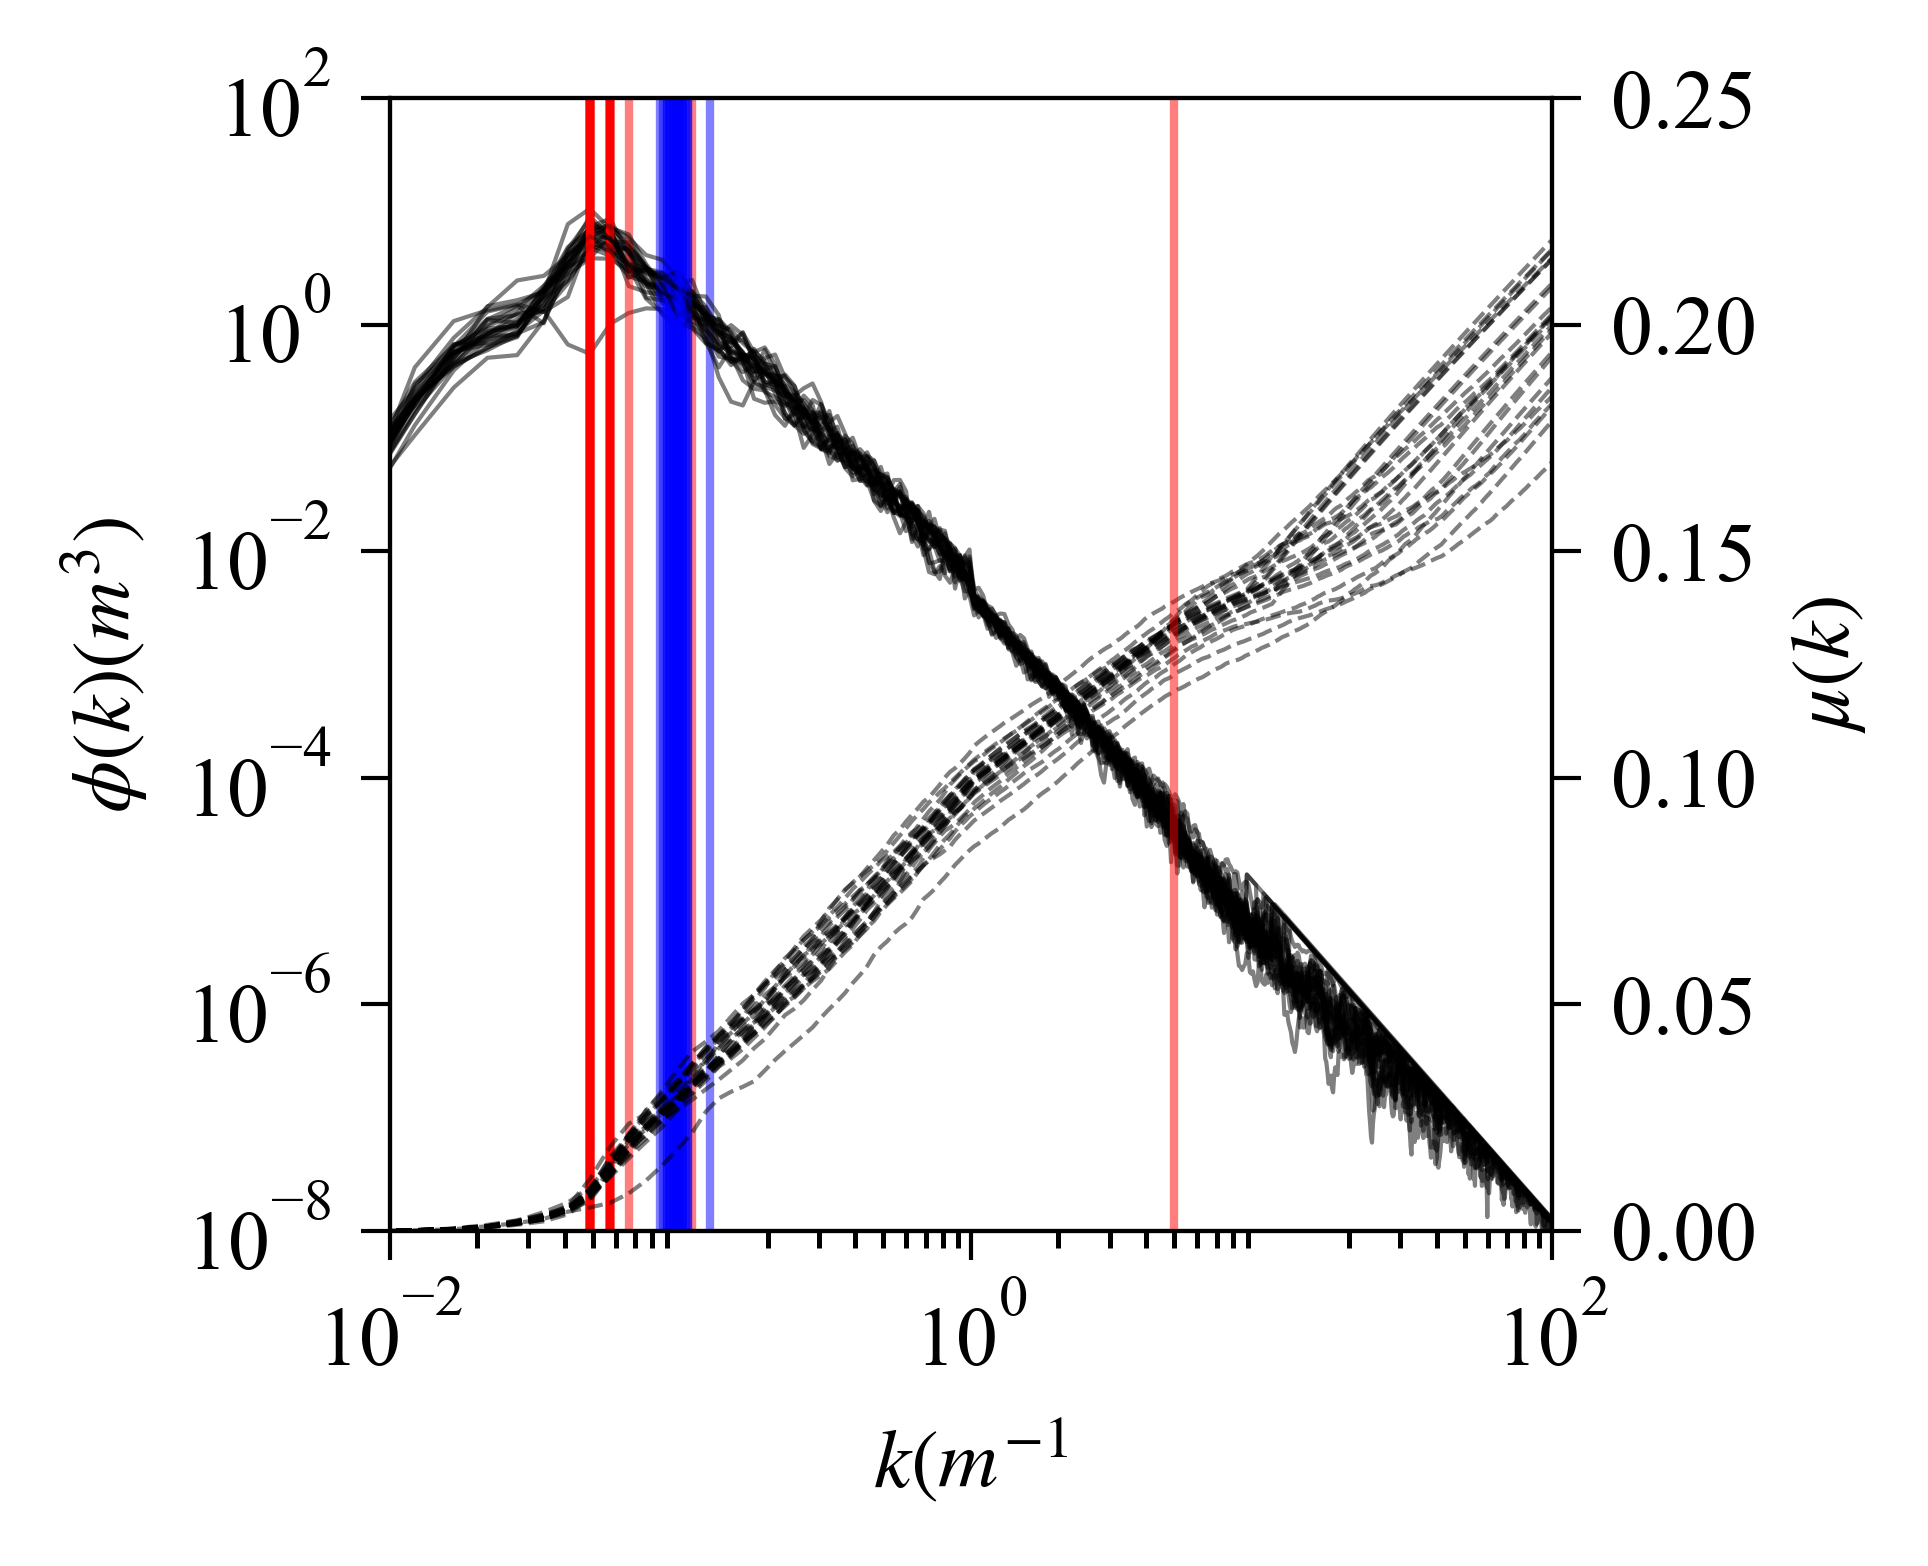

In [10]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()
ax2 = ax.twinx()

r09_ensem = []
for i in range (0,25):
    r09_spec = pd.read_csv('data/r09_25/spec_%g.txt' %(i+1), delimiter = ',')
    r09_Lc = pd.read_csv('data/r09_25/lambda_%g.txt' %(i+1), delimiter = ',')
    mu, Hs = steepness_trunc_non_uniform (r09_spec.Eom, r09_spec.k)
    ax.plot(r09_spec.k[1:], r09_spec.Eom[1:], c='k', alpha=0.5, lw=0.5)
    ax2.plot(r09_spec.k[1:], mu[1:], '--',  c='k', alpha=0.5, lw=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([0.01,100]) 
    ax.set_ylim([10**(-8.),10**(2.)])
    
    index = np.where(r09_spec.Eom == np.max(r09_spec.Eom))[0]
    print(index)
    ax.axvline(x=9.8/r09_add.cp[i]**2, c='b', alpha = 0.5, lw=1)
    ax.axvline(x=r09_spec.k[index[0]], c='r', alpha = 0.5, lw=1)
    indices = [idx for idx,val in enumerate(r09_spec.k) if val < 5]
    data = {"sigma_trunc": mu[indices[-1]], "k": r09_spec.k, "phi": r09_spec.Eom, "c": r09_Lc.c, "L": r09_Lc.Lambda, "cp": (9.8/r09_spec.k[index[0]])**0.5}
    r09_ensem.append(data)
    

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.01,100]) 
ax.set_ylim([10**(-8.),10**(2.)])
ax2.set_ylim([0,0.25])
ax.set_xlabel(r'$k(m^{-1}$')
ax.set_ylabel(r'$\phi(k)(m^{3})$')
ax2.set_ylabel(r'$\mu(k)$')
plt.axvline(x=5, c='r', alpha = 0.5, lw=1)

from matplotlib import ticker as mticker
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))


In [5]:
sigma = [data['sigma_trunc'] for data in r09_ensem]
print(np.array(sigma).max(), np.array(sigma).min())

0.13879748931497757 0.1190346488847811


Text(0, 0.5, '$\\Lambda(c) (m^{-2}s)$')

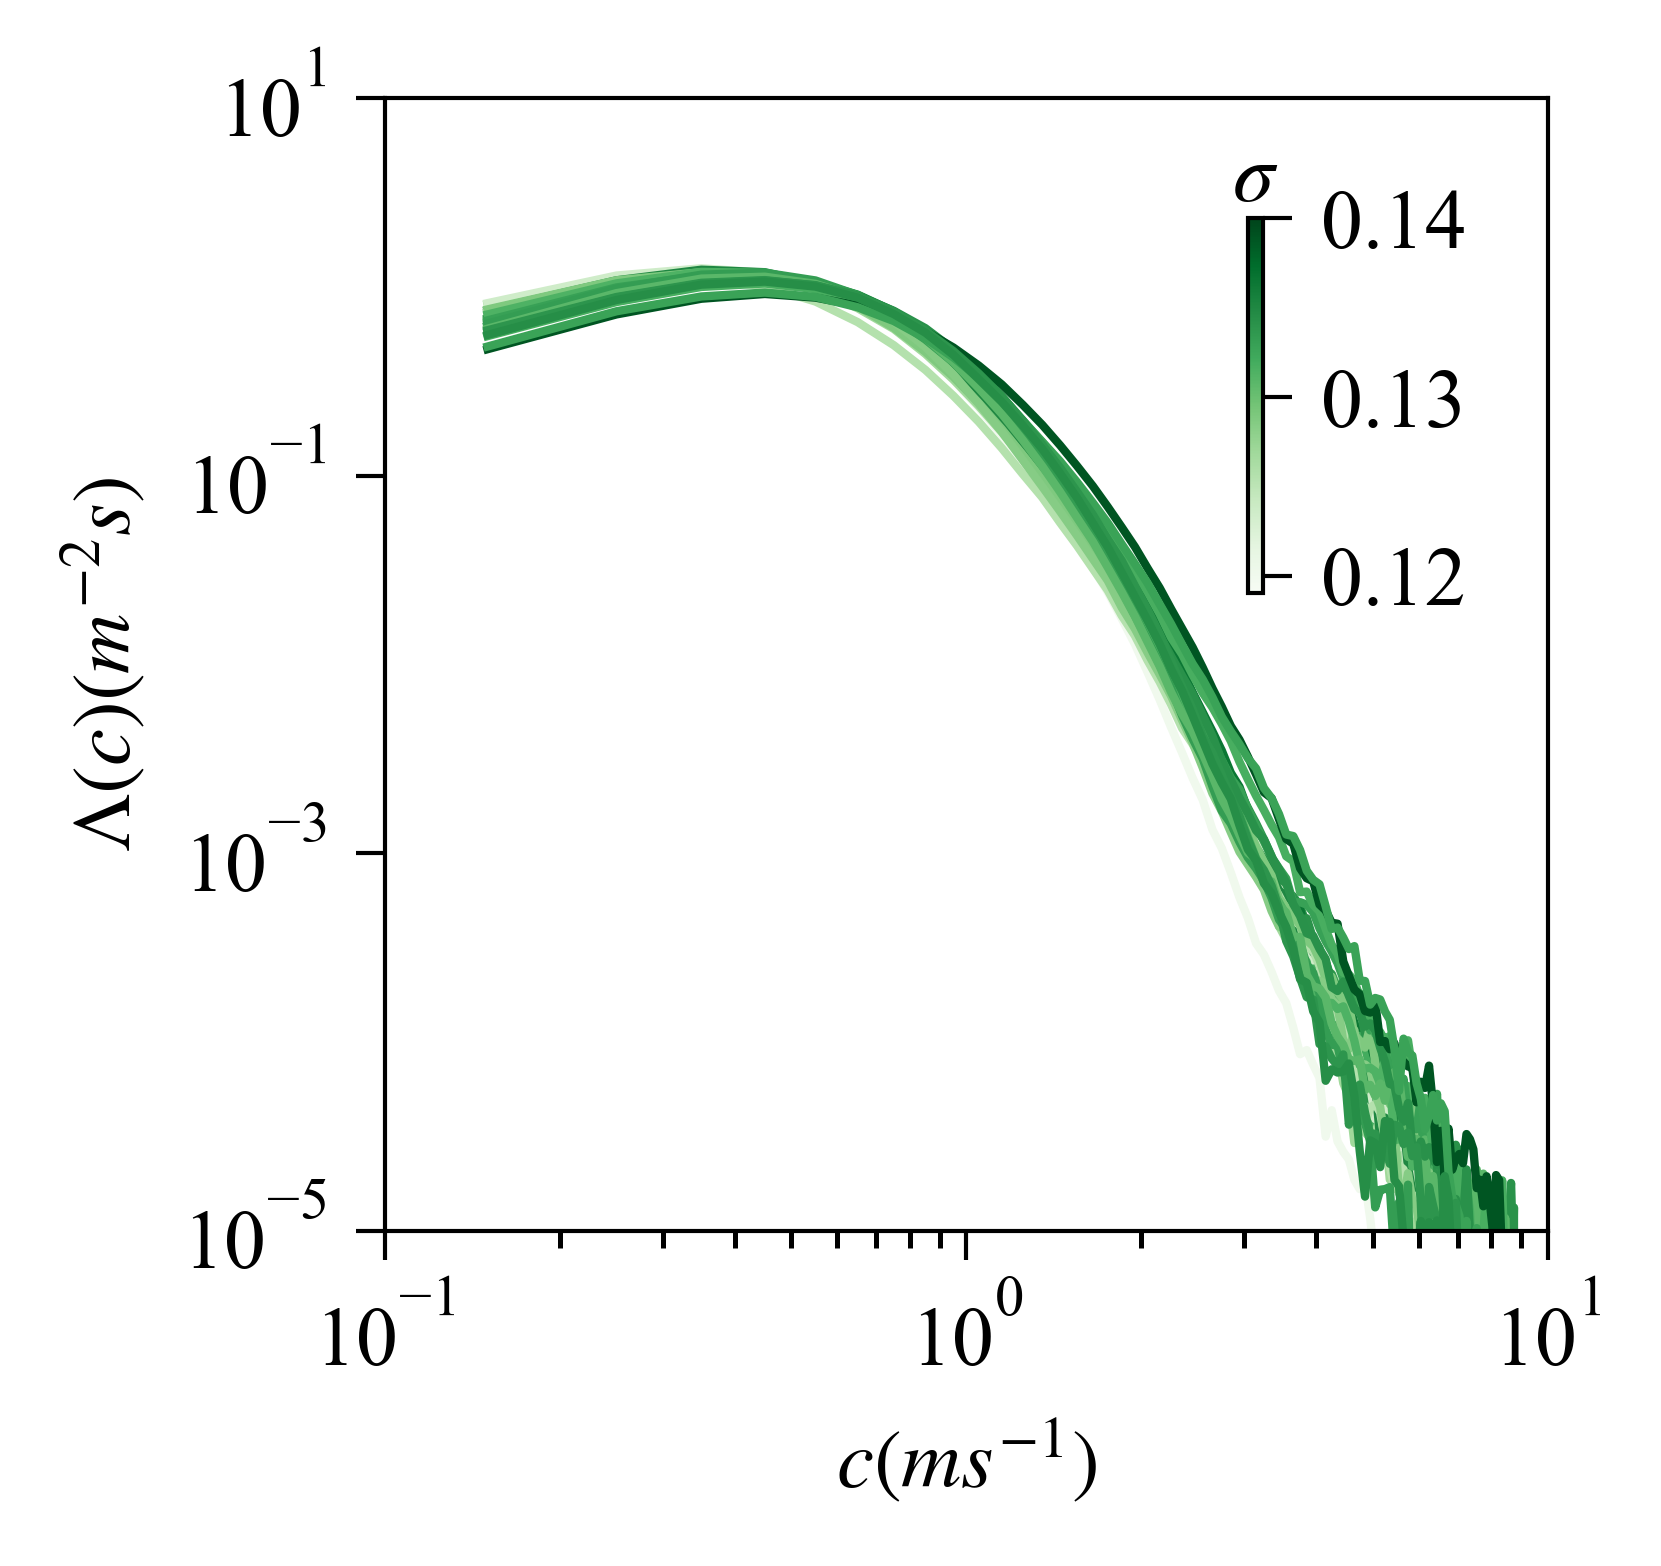

In [6]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()

for i in range (0,24):
    if r09_add.cp[i] != 'nan':
        color = plt.get_cmap('Greens')((r09_ensem[i]['sigma_trunc']-0.118)/(0.14-0.118))
        ax.plot(r09_ensem[i]['c'][1:], r09_ensem[i]['L'][1:], c=color, lw=1)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim([0.1,10]) 
        ax.set_ylim([10**(-5.),10**(1.)])
        
ax2  = fig.add_axes([0.7,0.55,0.01,0.25])
norm = mpl.colors.Normalize(vmin=0.119,vmax=0.14)
cbar = mpl.colorbar.ColorbarBase(ax2,cmap=plt.get_cmap('Greens'),norm=norm,orientation='vertical',ticks=(0.12,0.13,0.14))
cbar.ax.text(0.5, 1.1, r'$\sigma$', ha='center', va='center', transform=cbar.ax.transAxes)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.1,10]) 
ax.set_ylim([10**(-5.),10**(1.)])
ax.set_xlabel(r'$c(m s^{-1})$')
ax.set_ylabel(r'$\Lambda(c) (m^{-2}s)$')

In [11]:
CU_ensem = np.zeros(25)
for i in range (0,25):
    if (np.isnan(r09_add.cp[i]) == False):
        CU = r09_add.cp[i]/r09_add.ustar[i]
        CU_ensem[i] = CU

print(np.array(CU_ensem).max(), np.array(CU_ensem[np.nonzero(CU_ensem)]).min())

41.04379847406011 23.54376981016857


Text(0, 0.5, '$\\Lambda(c) (m^{-2}s)$')

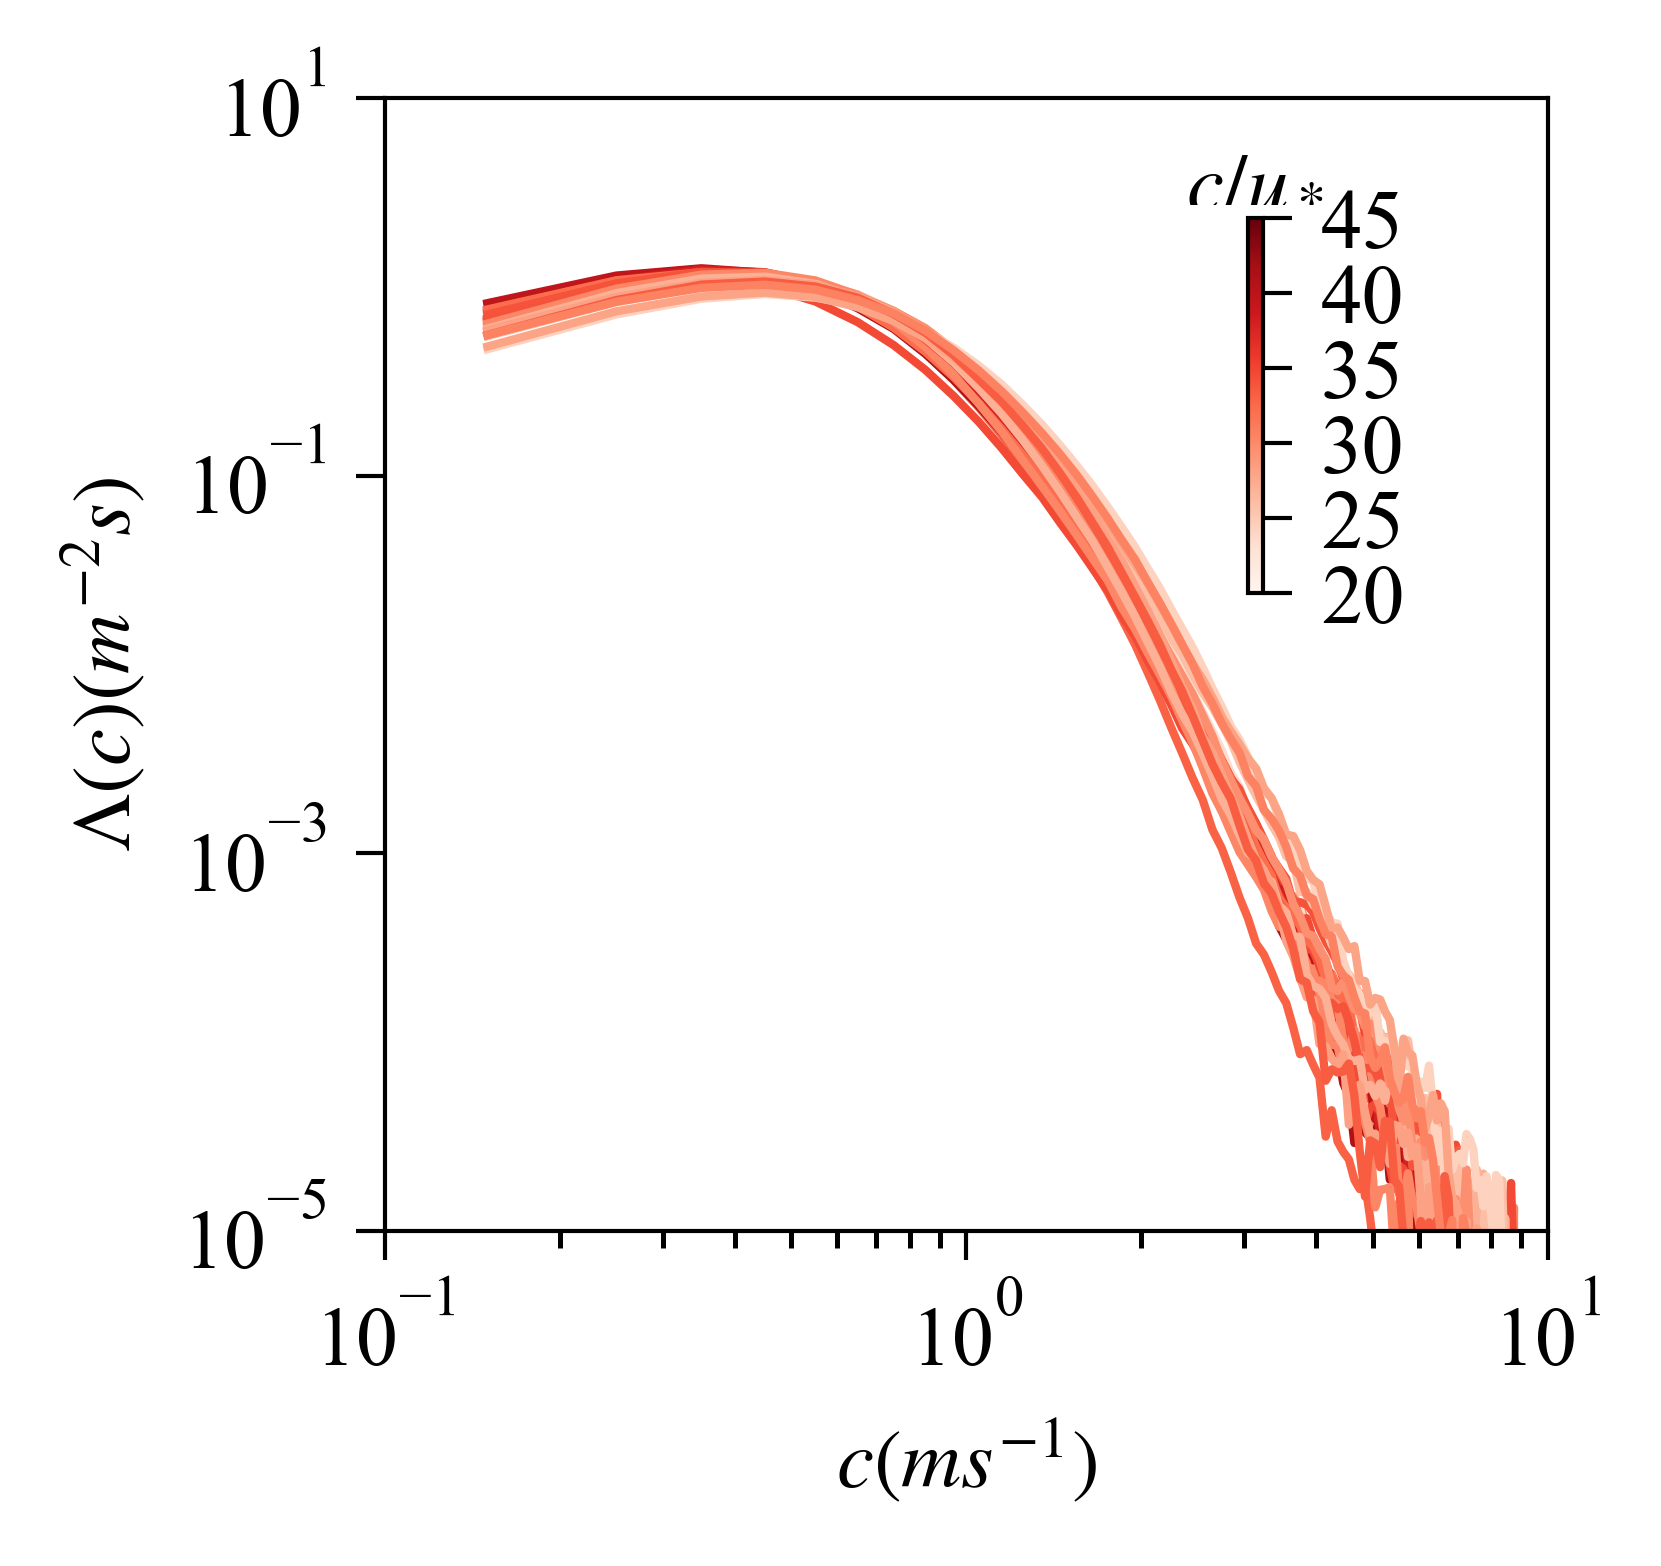

In [8]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()

for i in range (0,25):
    if (np.isnan(r09_add.cp[i]) == False):
        color = plt.get_cmap('Reds')((CU_ensem[i]-20)/(45-20))
        ax.plot(r09_ensem[i]['c'][1:], r09_ensem[i]['L'][1:], c=color, lw=1)
    
ax2  = fig.add_axes([0.7,0.55,0.01,0.25])
norm = mpl.colors.Normalize(vmin=20,vmax=45)
cbar = mpl.colorbar.ColorbarBase(ax2,cmap=plt.get_cmap('Reds'),norm=norm,orientation='vertical',ticks=(20,25,30,35,40,45))
cbar.ax.text(0.5, 1.1, r'$c/u_*$', ha='center', va='center', transform=cbar.ax.transAxes)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.1,10]) 
ax.set_ylim([10**(-5.),10**(1.)])
ax.set_xlabel(r'$c(m s^{-1})$')
ax.set_ylabel(r'$\Lambda(c) (m^{-2}s)$')

Text(0, 0.5, '$\\Lambda(c) (c_p^3g^{-1}\\sigma^{-2})$')

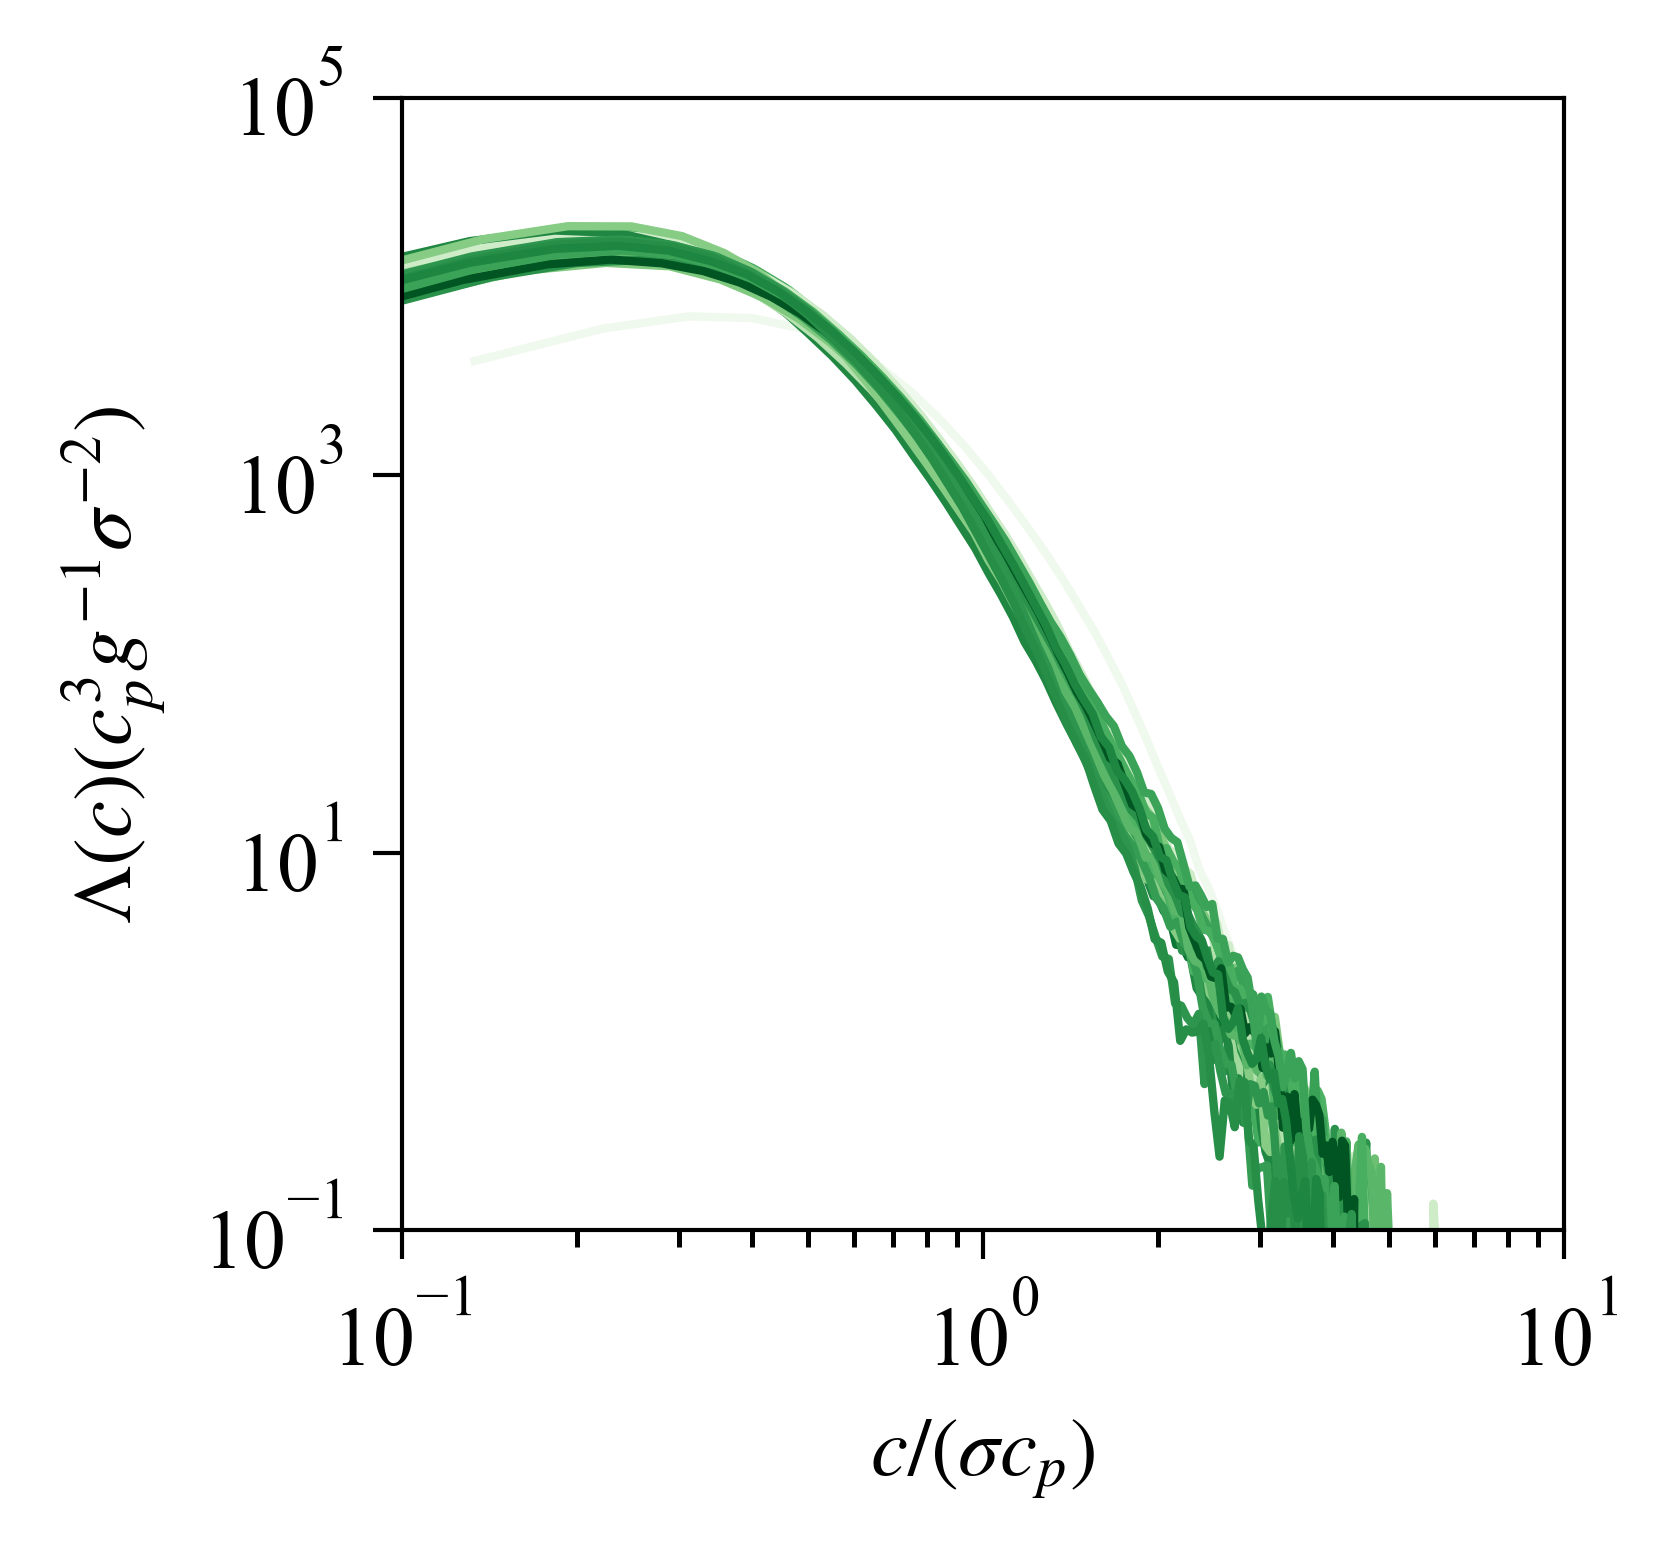

In [11]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()

for i in range (0,25):
    if (np.isnan(r09_add.cp[i]) == False):
        color = plt.get_cmap('Greens')((r09_ensem[i]['sigma_trunc']-0.118)/(0.14-0.118))
        """ cp from dataset """
#         c_hat = r09_ensem[i]['c'][1:]/(r09_add.cp[i]*r09_ensem[i]['sigma_trunc'])
#         lambdac_hat = r09_ensem[i]['L'][1:]*r09_add.cp[i]**3/9.8/r09_ensem[i]['sigma_trunc']**2
#         sigma = r09_ensem[i]['sigma_trunc']
#         ax.plot(c_hat, lambdac_hat, c=color, lw=1)
        """ One uniform cp from swell peak """
#         ax.plot(r09_ensem[i]['c'][1:]/(cp_uni*r09_ensem[i]['sigma_trunc']), 
#                 r09_ensem[i]['L'][1:]*cp_uni**3/9.8/r09_ensem[i]['sigma_trunc']**2, c=color, lw=1)
        """ sp from spectral peak """
        c_hat = r09_ensem[i]['c'][1:]/(r09_ensem[i]['cp']*r09_ensem[i]['sigma_trunc'])
        lambdac_hat = r09_ensem[i]['L'][1:]*r09_ensem[i]['cp']**3/9.8/r09_ensem[i]['sigma_trunc']**2
        sigma = r09_ensem[i]['sigma_trunc']
        ax.plot(c_hat, lambdac_hat, c=color, lw=1)
        
        file = open("./data/r09_25/Newscaling_r09_%d.csv" %(i+1), "w")
        fieldnames = ['hat{c}', 'hat{Lambda(c)}', 'sigma']
        writer = csv.writer(file)
        writer.writerow(fieldnames) 
        for c, lambdac in zip(c_hat, lambdac_hat):
            writer.writerow([round(c, 3), round(lambdac, 6), round(s10_ensem[i]['sigma_trunc'], 4)])           
        file.close()  

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.1,10]) 
ax.set_ylim([10**(-1.),10**(5.)])
ax.set_xlabel(r'$c/(\sigma c_p)$')
ax.set_ylabel(r'$\Lambda(c) (c_p^3g^{-1}\sigma^{-2})$')

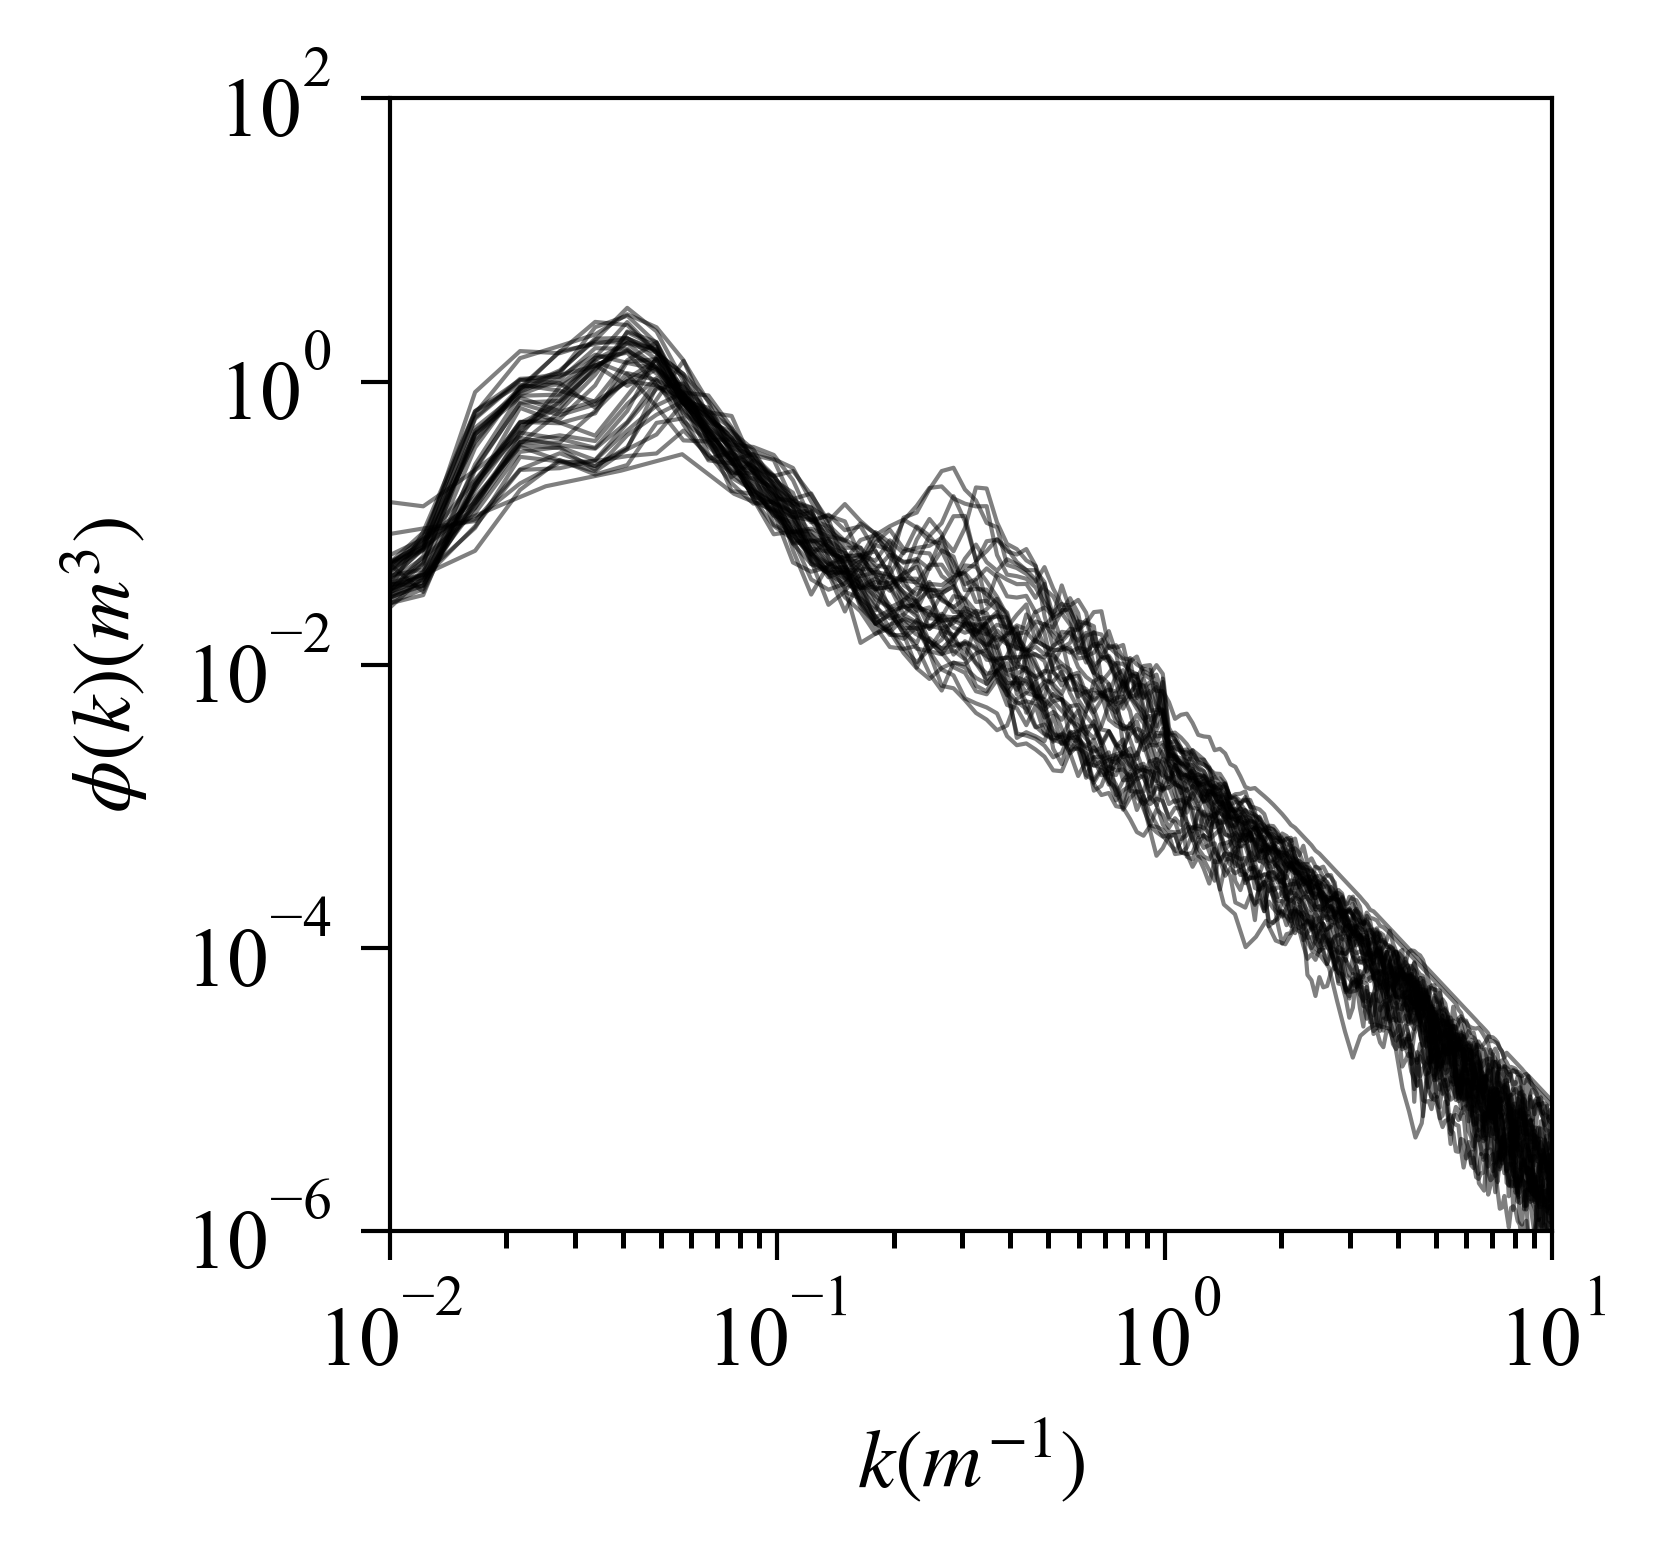

In [4]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()
# ax2 = ax.twinx()

s10_ensem = []
for i in range (0,39):
    s10_spec = pd.read_csv('data/s10_39/spec_%g.txt' %(i+1), delimiter = ',')
    s10_Lc = pd.read_csv('data/s10_39/lambda_%g.txt' %(i+1), delimiter = ',')
    mu, Hs = steepness_trunc_non_uniform (s10_spec.Eom, s10_spec.k)
    ax.plot(s10_spec.k[1:], s10_spec.Eom[1:], c='k', alpha=0.5, lw=0.5)
#     ax2.plot(s10_spec.k[1:], mu[1:], '--',  c='k', alpha=0.5, lw=0.5)
    indices = [idx for idx,val in enumerate(s10_spec.k) if val < 5]
    data = {"sigma_trunc": mu[indices[-1]], "k": s10_spec.k, "phi": s10_spec.Eom, "c": s10_Lc.c, "L": s10_Lc.Lambda}
    s10_ensem.append(data)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.01,10]) 
ax.set_ylim([10**(-6.),10**(2.)])
# ax2.set_ylim([0,0.25])
ax.set_xlabel(r'$k(m^{-1})$')
ax.set_ylabel(r'$\phi(k)(m^3)$')
# ax2.set_ylabel(r'$\mu(k)$')
# plt.axvline(x=5, c='r', alpha = 0.5, lw=1)

from matplotlib import ticker as mticker
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))


[11]
[12]
[11]
[10]
[11]
[10]
[11]
[10]
[11]
[11]
[11]
[10]
[11]
[11]
[11]
[10]
[10]
[11]
[11]
[11]
[11]
[11]
[12]
[11]
[12]
[12]
[12]
[12]
[12]
[12]
[13]
[12]
[13]
[13]
[13]
[13]
[13]
[13]
[6]


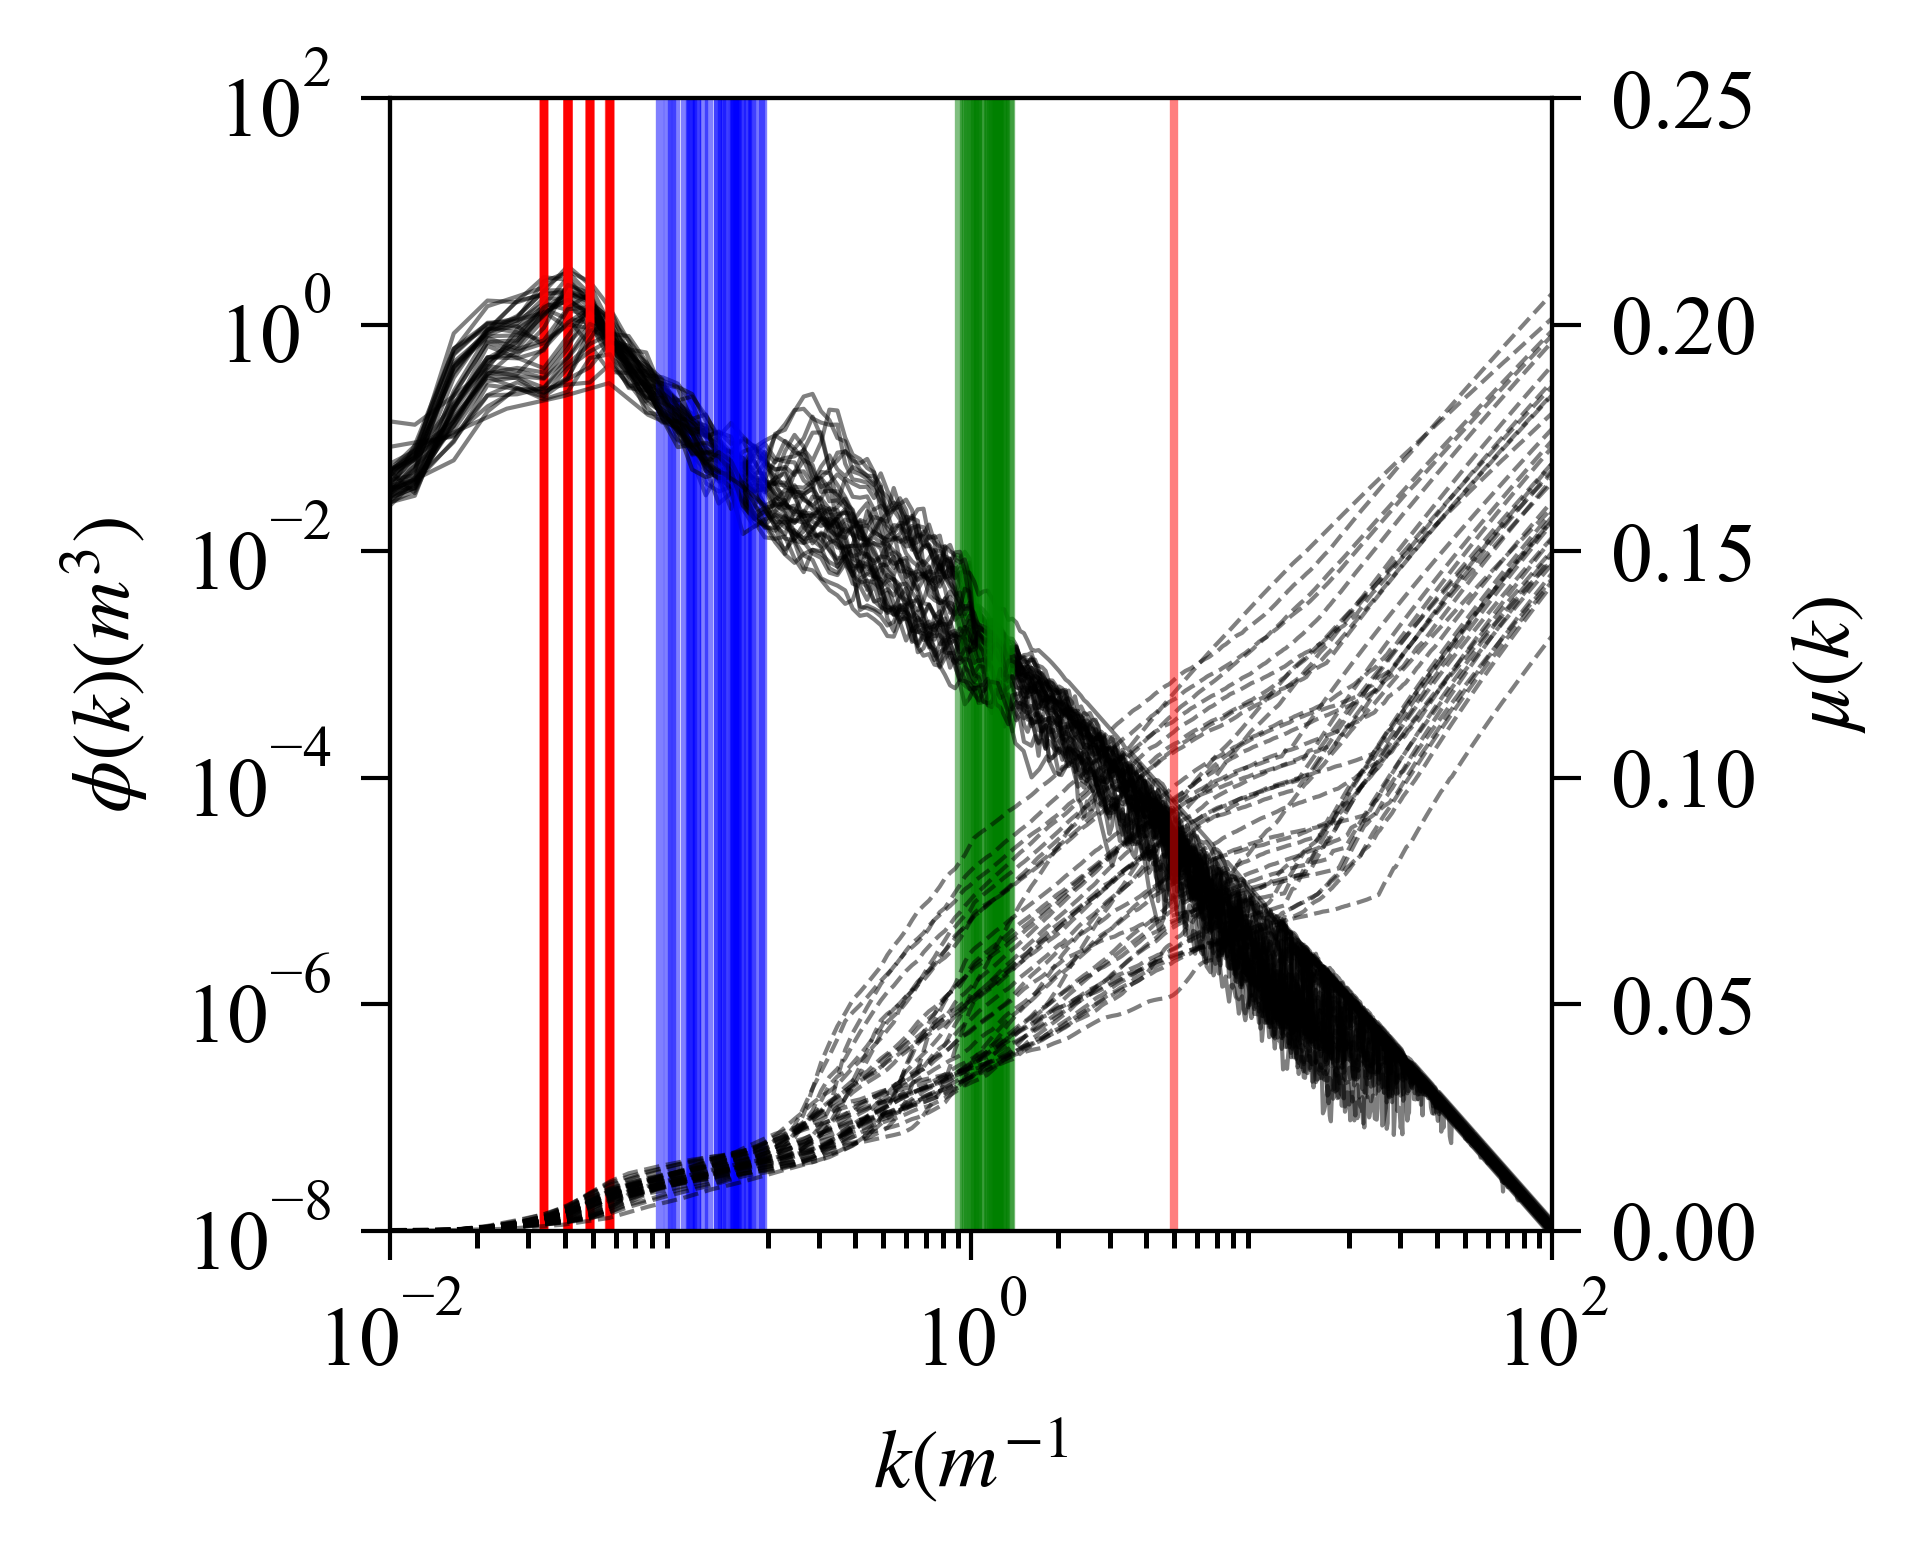

In [4]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()
ax2 = ax.twinx()

s10_ensem = []
for i in range (0,39):
    s10_spec = pd.read_csv('data/s10_39/spec_%g.txt' %(i+1), delimiter = ',')
    s10_Lc = pd.read_csv('data/s10_39/lambda_%g.txt' %(i+1), delimiter = ',')
    mu, Hs = steepness_trunc_non_uniform (s10_spec.Eom, s10_spec.k)
    ax.plot(s10_spec.k[1:], s10_spec.Eom[1:], c='k', alpha=0.5, lw=0.5)
    ax2.plot(s10_spec.k[1:], mu[1:], '--',  c='k', alpha=0.5, lw=0.5)
    index = np.where(s10_spec.Eom == np.max(s10_spec.Eom))[0]
    print(index)
    ax.axvline(x=9.8/s10_add.cp[i]**2, c='b', alpha = 0.5, lw=1)
    ax.axvline(x=s10_add.kp[i], c='g', alpha = 0.5, lw=1) # kp is being weird
    ax.axvline(x=s10_spec.k[index[0]], c='r', alpha = 0.5, lw=1)
    indices = [idx for idx,val in enumerate(s10_spec.k) if val < 5]
    data = {"sigma_trunc": mu[indices[-1]], "k": s10_spec.k, "phi": s10_spec.Eom, "c": s10_Lc.c, "L": s10_Lc.Lambda, "cp": (9.8/s10_spec.k[index[0]])**0.5}
    s10_ensem.append(data)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.01,100]) 
ax.set_ylim([10**(-8.),10**(2.)])
ax2.set_ylim([0,0.25])
ax.set_xlabel(r'$k(m^{-1}$')
ax.set_ylabel(r'$\phi(k)(m^3)$')
ax2.set_ylabel(r'$\mu(k)$')
plt.axvline(x=5, c='r', alpha = 0.5, lw=1)

from matplotlib import ticker as mticker
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))


In [13]:
sigma = [data['sigma_trunc'] for data in s10_ensem]
print(np.array(sigma).max(), np.array(sigma).min())

0.12148021662200675 0.05202286881574143


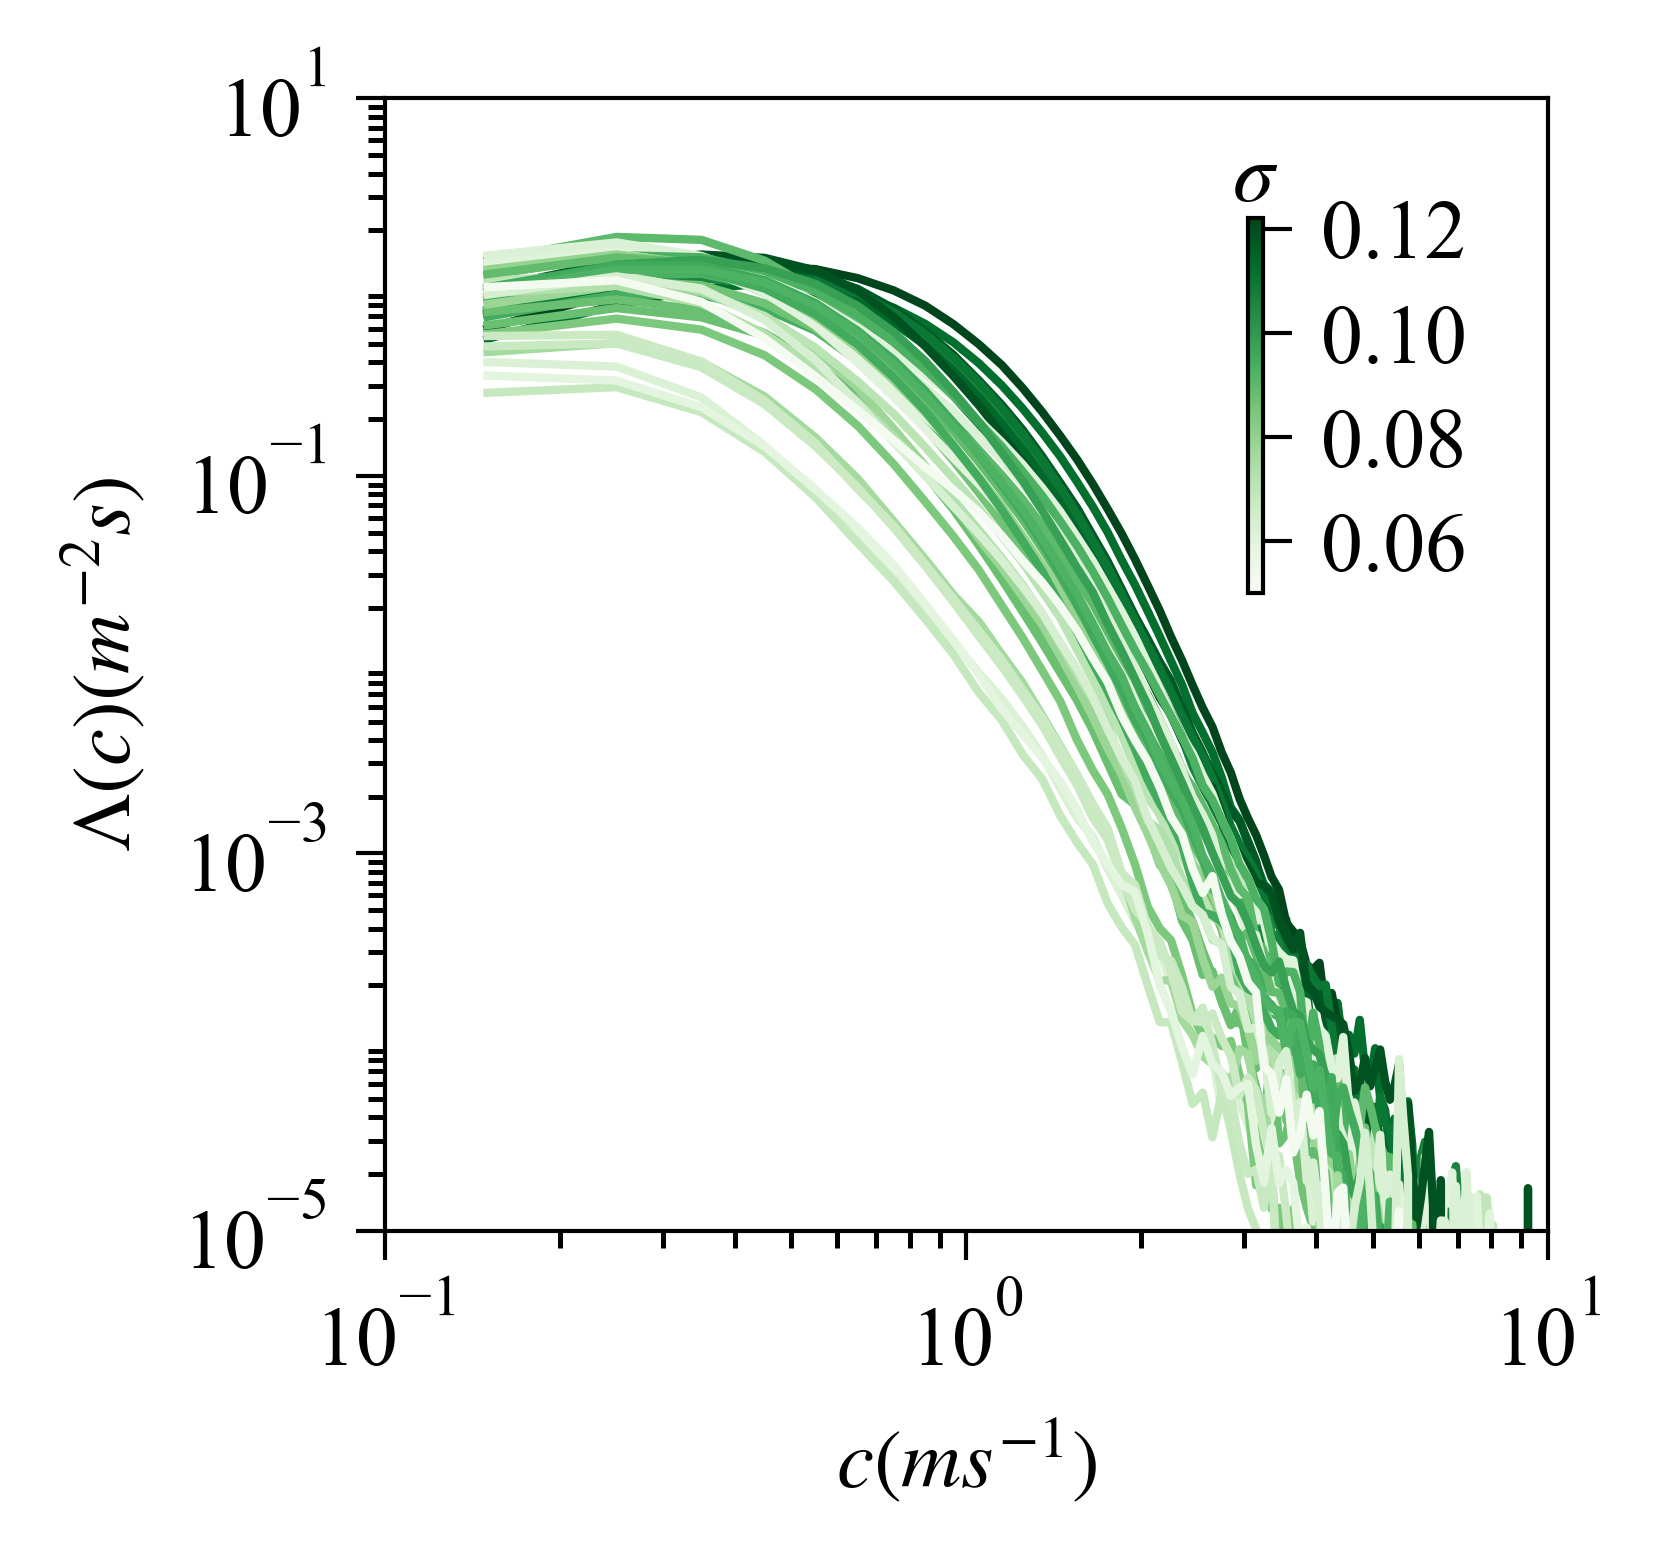

In [10]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()

for i in range (0,39):
    color = plt.get_cmap('Greens')((s10_ensem[i]['sigma_trunc']-0.05)/(0.122-0.05))
    ax.plot(s10_ensem[i]['c'][1:], s10_ensem[i]['L'][1:], c=color, lw=1)
    
ax2  = fig.add_axes([0.7,0.55,0.01,0.25])
norm = mpl.colors.Normalize(vmin=0.05,vmax=0.122)
cbar = mpl.colorbar.ColorbarBase(ax2,cmap=plt.get_cmap('Greens'),norm=norm,orientation='vertical',ticks=(0.06,0.08,0.1,0.12))
cbar.ax.text(0.5, 1.1, r'$\sigma$', ha='center', va='center', transform=cbar.ax.transAxes)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.1,10]) 
ax.set_ylim([10**(-5.),10**(1.)])
ax.set_xlabel(r'$c(m s^{-1})$')
ax.set_ylabel(r'$\Lambda(c) (m^{-2}s)$')

from matplotlib import ticker as mticker
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

### What about the wave age metric

In [15]:
CU_ensem = np.zeros(39)
for i in range (0,39):
    if (np.isnan(s10_add.cp[i]) == False):
        CU = s10_add.cp[i]/s10_add.ustar[i]
        CU_ensem[i] = CU

print(np.array(CU_ensem).max(), np.array(CU_ensem[np.nonzero(CU_ensem)]).min())

148.24415578315157 20.93559872630747


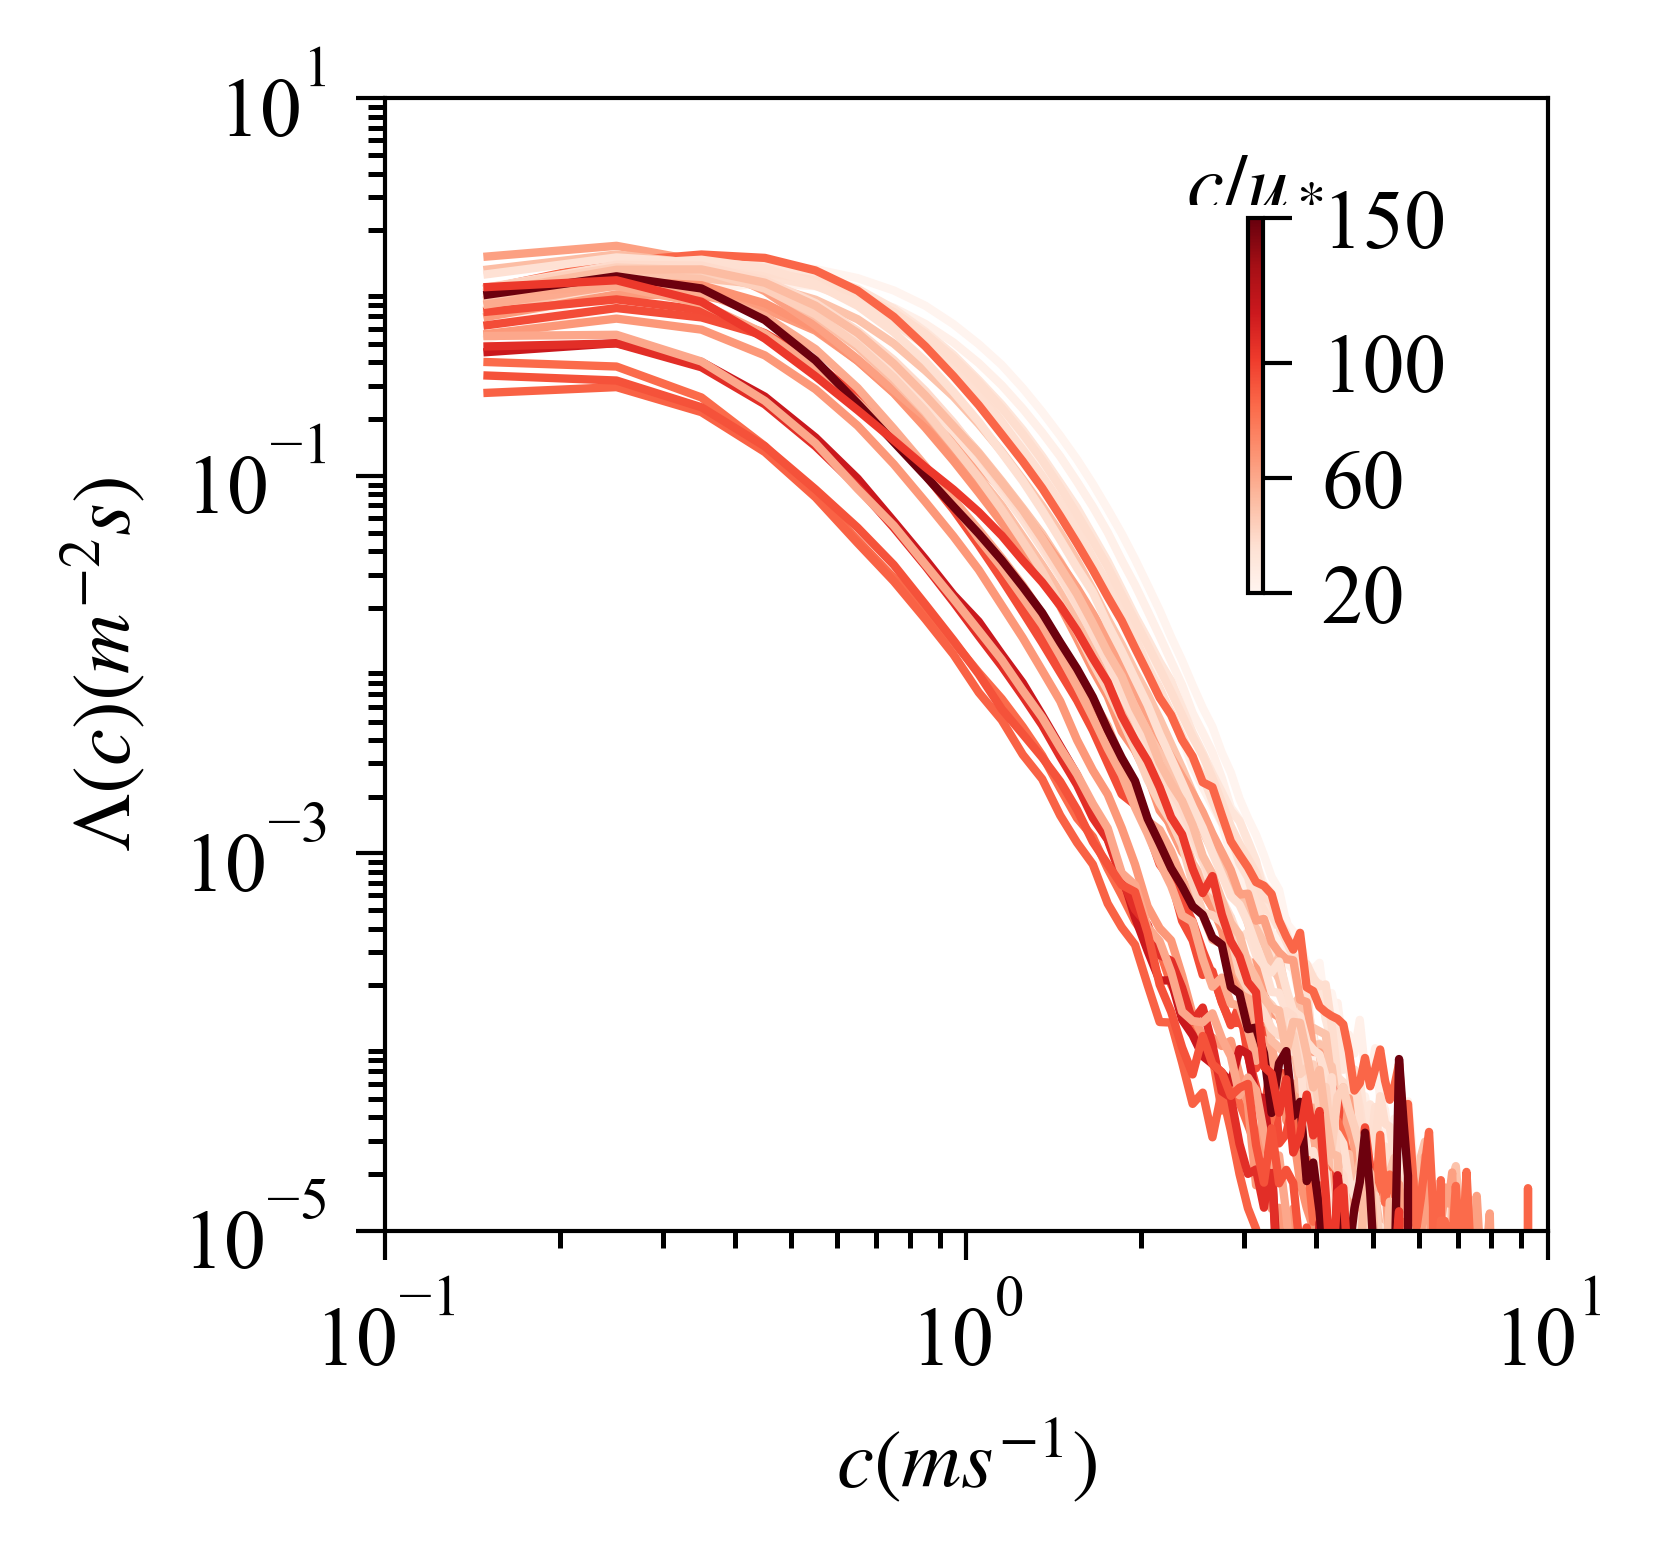

In [16]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()

for i in range (0,39):
    if (np.isnan(s10_add.cp[i]) == False):
        color = plt.get_cmap('Reds')((CU_ensem[i]-20)/(150-20))
        ax.plot(s10_ensem[i]['c'][1:], s10_ensem[i]['L'][1:], c=color, lw=1)
    
ax2  = fig.add_axes([0.7,0.55,0.01,0.25])
norm = mpl.colors.Normalize(vmin=20,vmax=150)
cbar = mpl.colorbar.ColorbarBase(ax2,cmap=plt.get_cmap('Reds'),norm=norm,orientation='vertical',ticks=(20,60,100,150))
cbar.ax.text(0.5, 1.1, r'$c/u_*$', ha='center', va='center', transform=cbar.ax.transAxes)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.1,10]) 
ax.set_ylim([10**(-5.),10**(1.)])
ax.set_xlabel(r'$c(m s^{-1})$')
ax.set_ylabel(r'$\Lambda(c) (m^{-2}s)$')

from matplotlib import ticker as mticker
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))


15.455391837341185
14.167442517562744
15.455391837341185
17.000931021075303
15.455391837341185
17.000931021075303
15.455391837341185
17.000931021075303
15.455391837341185
15.455391837341185
15.455391837341185
17.000931021075303
15.455391837341185
15.455391837341185
17.000931021075303
17.000931021075303
14.167442517562744
14.167442517562744
14.167442517562744
14.167442517562744
14.167442517562744
14.167442517562744
14.167442517562744
13.077639246980997
14.167442517562744
13.077639246980997
13.077639246980997
13.077639246980997
13.077639246980997
13.077639246980997
13.077639246980997


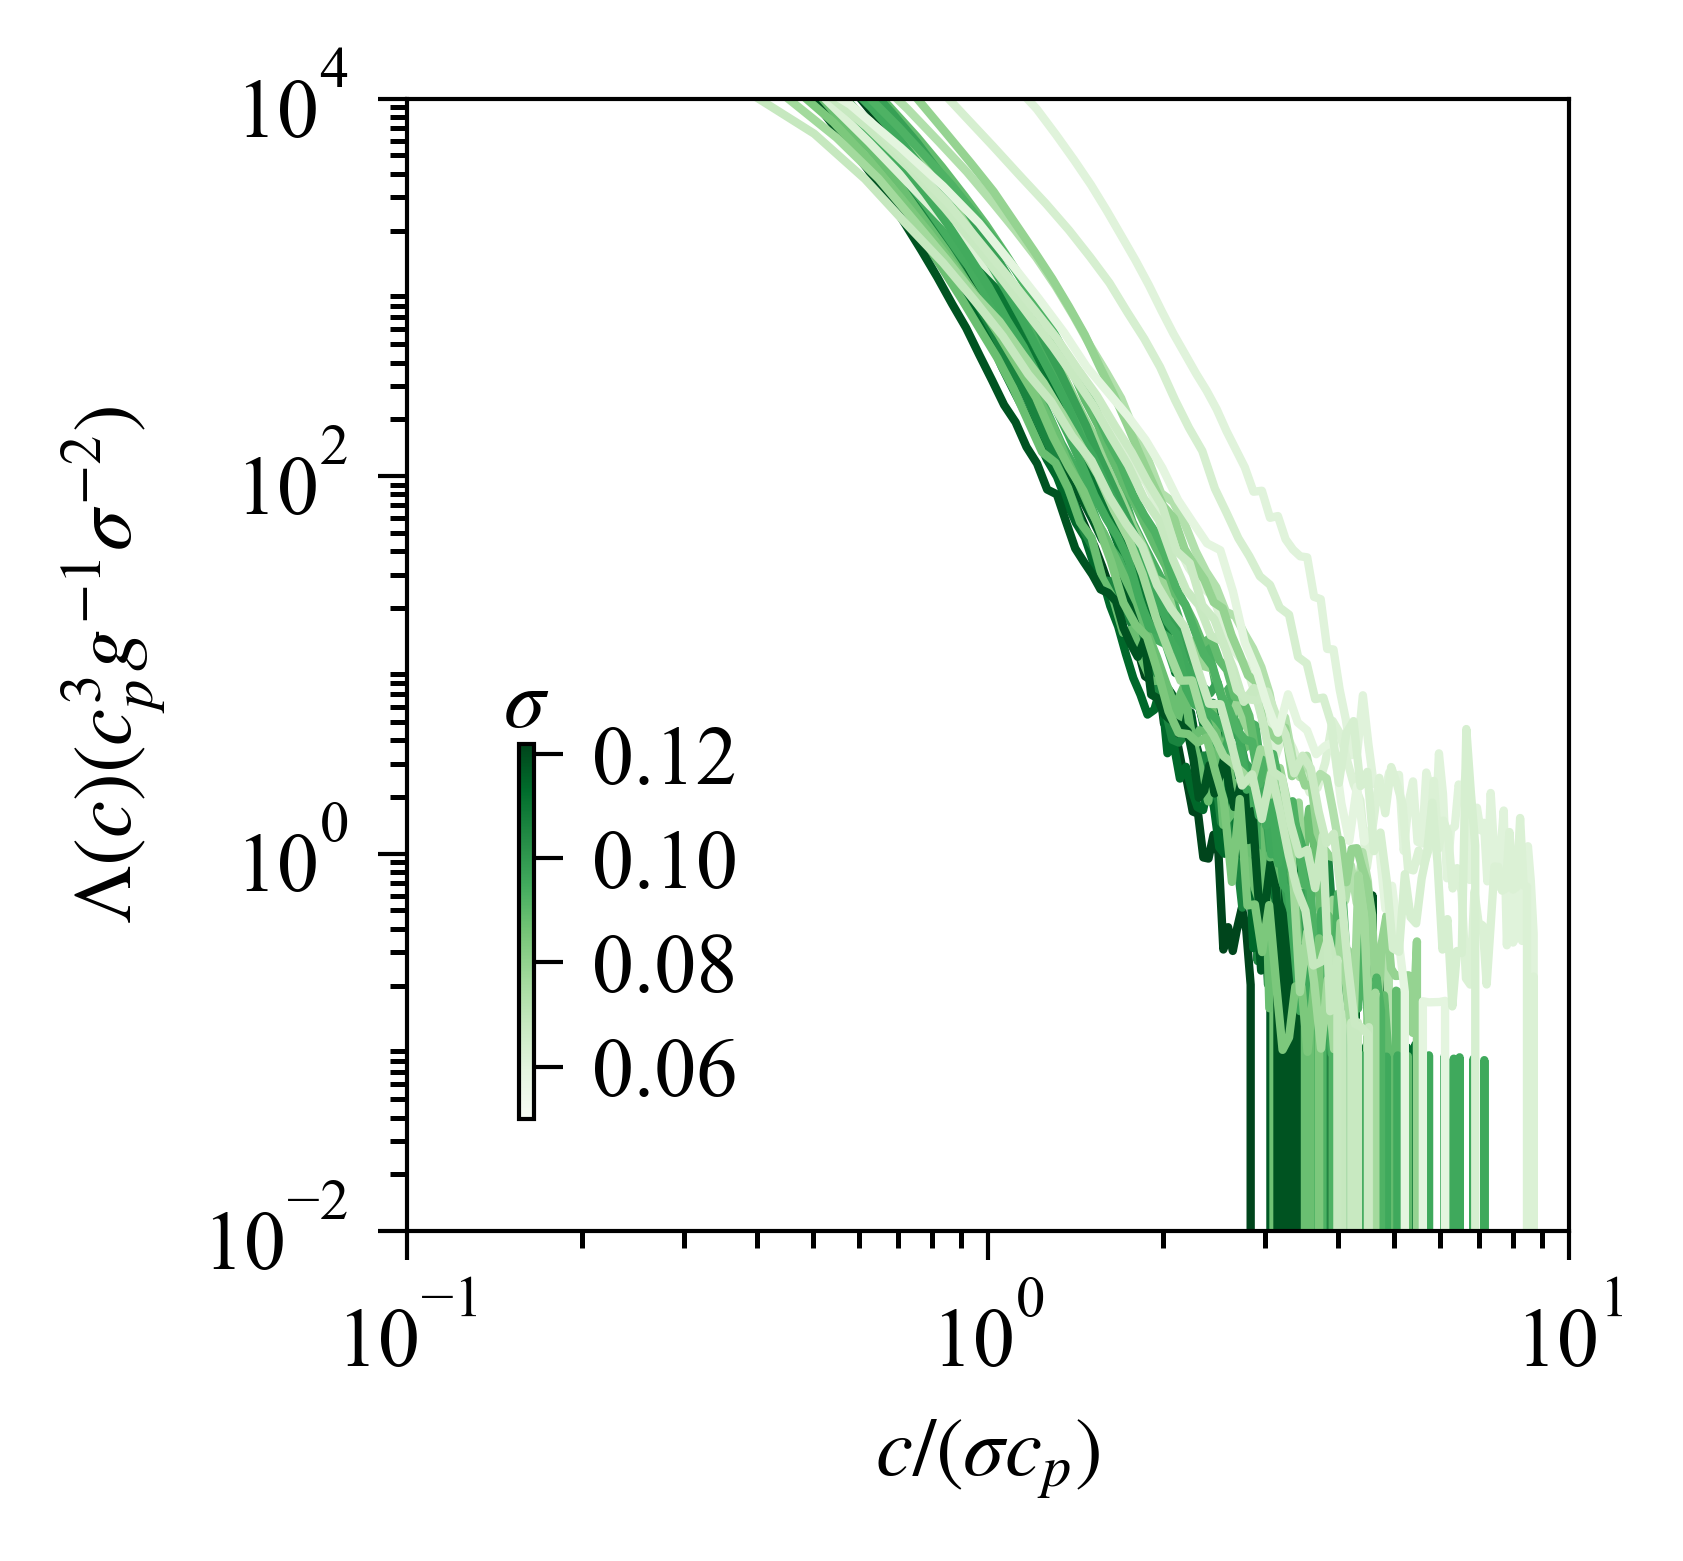

In [8]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()

for i in range (0,38):
    if (np.isnan(s10_add.cp[i]) == False):
        color = plt.get_cmap('Greens')((s10_ensem[i]['sigma_trunc']-0.05)/(0.122-0.05))
        """ cp from dataset """
#         ax.plot(s10_ensem[i]['c'][1:]/(s10_add.cp[i]*s10_ensem[i]['sigma_trunc']), 
#                 s10_ensem[i]['L'][1:]*s10_add.cp[i]**3/9.8/s10_ensem[i]['sigma_trunc']**2, c=color, lw=1)
        """ cp from dataset """
        print(s10_ensem[i]['cp'])
        c_hat = s10_ensem[i]['c'][1:]/(s10_ensem[i]['cp']*s10_ensem[i]['sigma_trunc'])
        lambdac_hat = s10_ensem[i]['L'][1:]*s10_ensem[i]['cp']**3/9.8/s10_ensem[i]['sigma_trunc']**2
        ax.plot(c_hat, lambdac_hat, c=color, lw=1)
        file = open("./data/s10_39/Newscaling_SolCal2013_%d.csv" %(i+1), "w")
        fieldnames = ['hat{c}', 'hat{Lambda(c)}', 'sigma']
        writer = csv.writer(file)
        writer.writerow(fieldnames) 
        for c, lambdac in zip(c_hat, lambdac_hat):
            writer.writerow([round(c, 3), round(lambdac, 6), round(s10_ensem[i]['sigma_trunc'], 4)])           
        file.close()  
#         """ One uniform cp from swell peak """
#         c_hat = s10_ensem[i]['c'][1:]/(cp_uni*s10_ensem[i]['sigma_trunc'])
#         lambdac_hat = s10_ensem[i]['L'][1:]*cp_uni**3/9.8/s10_ensem[i]['sigma_trunc']**2
#         ax.plot(c_hat, lambdac_hat, c=color, lw=1)
#         """ Write to a file """
#         file = open("./data/s10_39/Newscaling_SolCal2013_%d.csv" %(i+1), "w")
#         fieldnames = ['hat{c}', 'hat{Lambda(c)}', 'sigma']
#         writer = csv.writer(file)
#         writer.writerow(fieldnames) 
#         for c, lambdac in zip(c_hat, lambdac_hat):
#             writer.writerow([round(c, 3), round(lambdac, 6), round(s10_ensem[i]['sigma_trunc'], 4)])           
#         file.close()  

ax2  = fig.add_axes([0.2,0.2,0.01,0.25])
norm = mpl.colors.Normalize(vmin=0.05,vmax=0.122)
cbar = mpl.colorbar.ColorbarBase(ax2,cmap=plt.get_cmap('Greens'),norm=norm,orientation='vertical',ticks=(0.06,0.08,0.1,0.12))
cbar.ax.text(0.5, 1.1, r'$\sigma$', ha='center', va='center', transform=cbar.ax.transAxes)


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.1,10]) 
ax.set_ylim([10**(-2.),10**(4.)])
ax.set_xlabel(r'$c/(\sigma c_p)$')
ax.set_ylabel(r'$\Lambda(c) (c_p^3g^{-1}\sigma^{-2})$')
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
    

### Jessica Kleiss's data

In [5]:
JK_add

cp        kp        Hs     ustar
0   3.451219  0.287326  0.807972  0.611976
1   3.626685  0.165171  1.321592  0.582025
2   4.316337  0.115279  1.865466  0.576652
3   3.992626  0.093784  2.172483  0.561922
4   3.515841  0.063025  2.934442  0.465270
5   3.450647  0.061757  3.063217  0.466805
6   3.723582  0.201874  1.282192  0.769335
7   4.242877  0.127847  1.946391  0.835675
8   4.350000  0.096044  2.426022  0.830643
9   4.078295  0.088937  2.590847  0.826181
10  3.947987  0.057136  3.713459  0.662882
11  3.440148  0.052665  3.965370  0.718745
12  3.750000  0.047301  4.046060  0.663049
13  3.625719  0.051065  4.100182  0.629434
14  3.756602  0.056494  3.745421  0.632780
15  4.843081  0.056193  3.637917  0.835164
16  3.550683  0.097688  2.376472  0.715335
17  3.312802  0.135548  1.845310  0.757365
18  4.014695  0.214937  1.207461  0.748786
19  3.951267  0.114103  2.205790  0.640675
20  3.849623  0.097627  2.585798  0.678944
21  3.610846  0.070963  3.395381  0.764086
22  3.477326  0.063859  3.699388  0.744414
23  3.950000  0.052555  3.647187  0.704585
24  3.099145  0.049688  3.590899  0.681051
25  3.617352  0.051223  3.532239  0.634927
26  3.721594  0.051304  3.529110  0.632467
27  2.982580  0.054195  3.562323  0.603161
28  2.989446  0.051843  3.505941  0.583654
29  4.153166  0.047985  3.405927  0.546733
30  4.800125  0.048529  3.396479  0.534480
31  3.800200  0.049086  3.397318  0.522079
32  4.681758  0.050070  3.631434  0.480147
33  4.216495  0.048407  3.652563  0.464594
34  3.865692  0.182176  1.579151  0.499165
35  4.248439  0.128303  1.991022  0.553717

[9]
[32]
[27]
[18]
[13]
[13]
[53]
[26]
[19]
[17]
[11]
[8]
[9]
[10]
[12]
[12]
[23]
[31]
[37]
[20]
[22]
[15]
[13]
[10]
[10]
[10]
[10]
[10]
[10]
[9]
[12]
[12]
[10]
[9]
[6]
[27]


Text(0, 0.5, '$\\phi(k)(m^3)$')

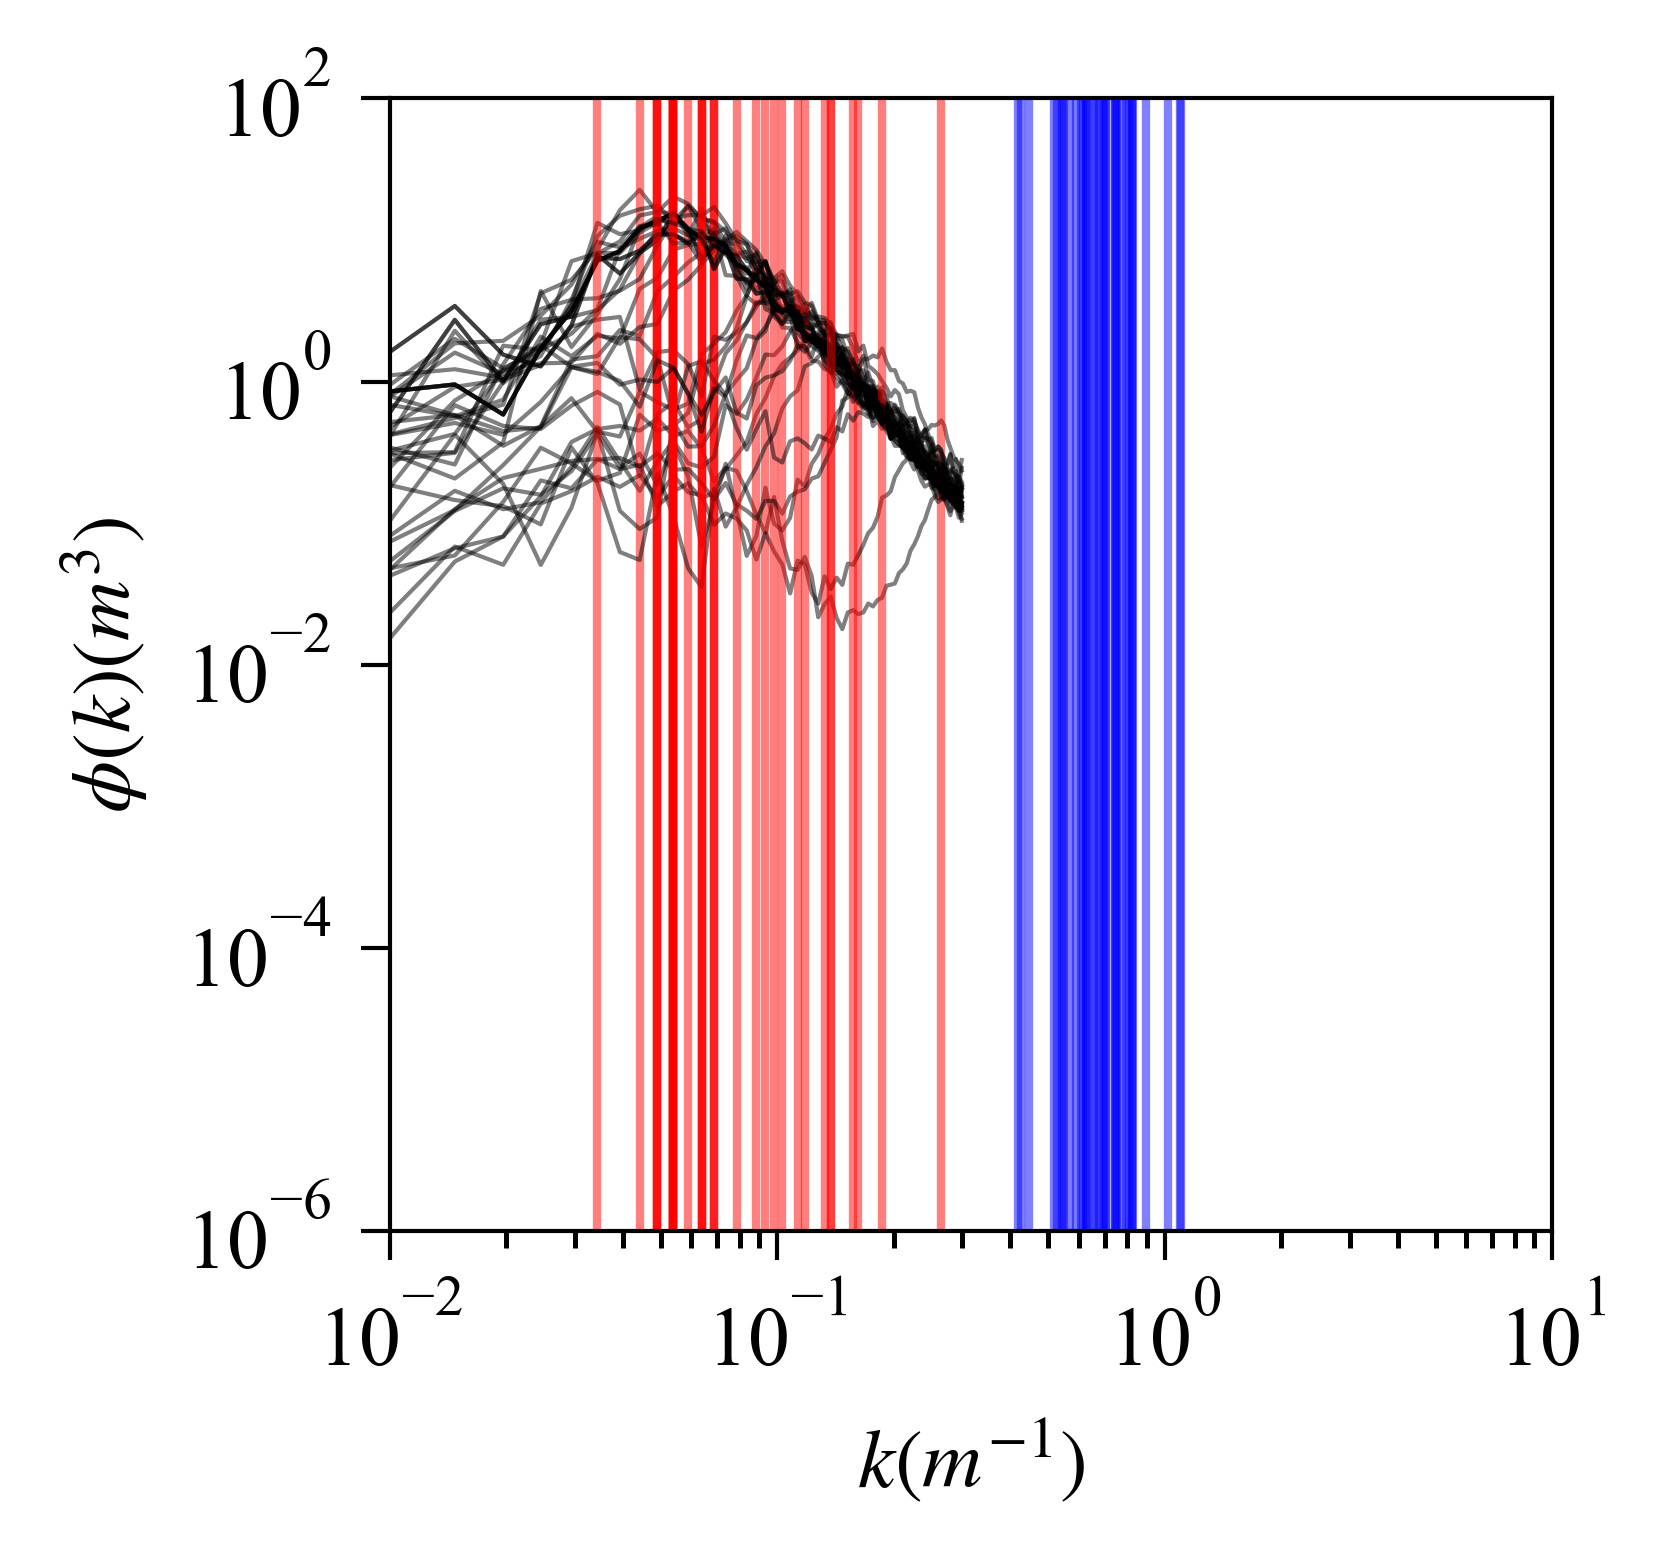

In [27]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()
# ax2 = ax.twinx()

JK_ensem = []
for i in range (0,36):
    JK_spec = pd.read_csv('data/JK_36/spec_%g.txt' %(i+1), delimiter = ',')
    JK_Lc = pd.read_csv('data/JK_36/lambda_%g.txt' %(i+1), delimiter = ',')
    mu, Hs = steepness_trunc_non_uniform (JK_spec.Eom, JK_spec.k)
    ax.plot(JK_spec.k[1:], JK_spec.Eom[1:], c='k', alpha=0.5, lw=0.5)
    index = np.where(JK_spec.Eom == np.max(JK_spec.Eom))[0]
    print(index)
    ax.axvline(x=9.8/JK_add.cp[i]**2, c='b', alpha = 0.5, lw=1)
#     if index[0] > 7:
    ax.axvline(x=JK_spec.k[index[0]], c='r', alpha = 0.5, lw=1)
    indices = [idx for idx,val in enumerate(JK_spec.k) if val < 5]
    data = {"sigma_trunc": mu[indices[-1]], "k": JK_spec.k, "phi": JK_spec.Eom, "c": JK_Lc.c, "L": JK_Lc.Lambda, "cp": (9.8/JK_spec.k[index[0]])**0.5}
    JK_ensem.append(data)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.01,10]) 
ax.set_ylim([10**(-6.),10**(2.)])
# ax2.set_ylim([0,0.2])
ax.set_xlabel(r'$k(m^{-1})$')
ax.set_ylabel(r'$\phi(k)(m^3)$')
# ax2.set_ylabel(r'$\mu(k)$')

Text(0, 0.5, '$B(k)=\\phi(k)k^3$')

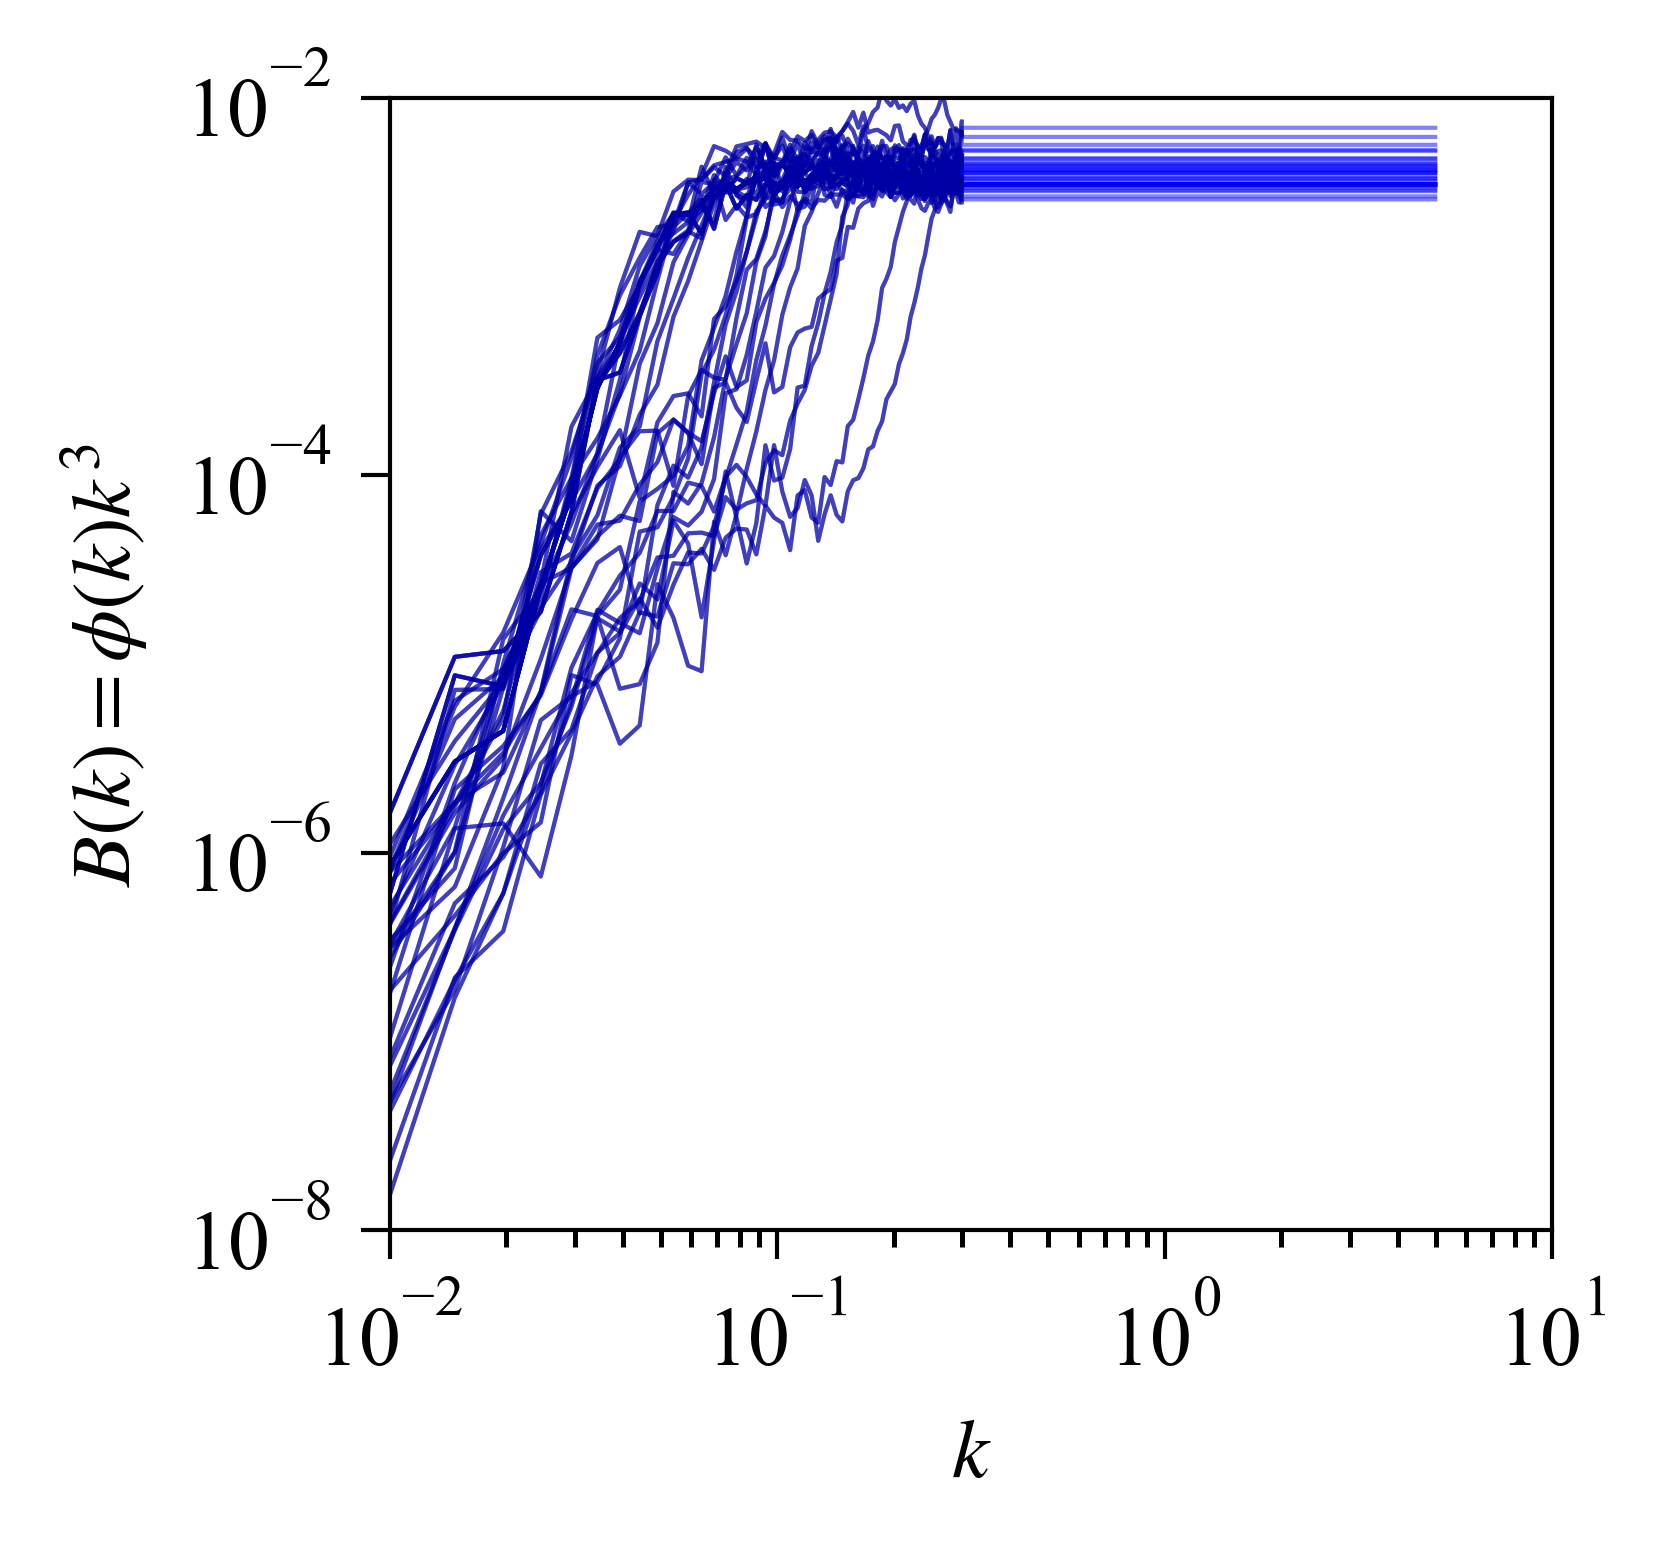

In [34]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()
for i in range (0,36):
    ax.plot(JK_ensem[i]['k'][1:], JK_ensem[i]['phi'][1:]*JK_ensem[i]['k'][1:]**3, c='k', alpha=0.5, lw=0.5)
    k_tail = np.arange(0.3,5,0.01)
    phi_tail = np.average(JK_ensem[i]['phi'][-5:-1]*JK_ensem[i]['k'][-5:-1]**3)*k_tail**(-3)
    JK_ensem[i]['k'] = np.concatenate((JK_ensem[i]['k'], k_tail), axis=0)
    JK_ensem[i]['phi'] = np.concatenate((JK_ensem[i]['phi'], phi_tail), axis=0)
    ax.plot(JK_ensem[i]['k'][1:], JK_ensem[i]['phi'][1:]*JK_ensem[i]['k'][1:]**3, c='b', alpha=0.5, lw=0.5)
ax.set_xscale('log')
ax.set_yscale('log')    
ax.set_xlim([0.01,10]) 
ax.set_ylim([10**(-8.),10**(-2.)])
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$B(k)=\phi(k)k^3$')

Text(0, 0.5, '$\\mu(k)$')

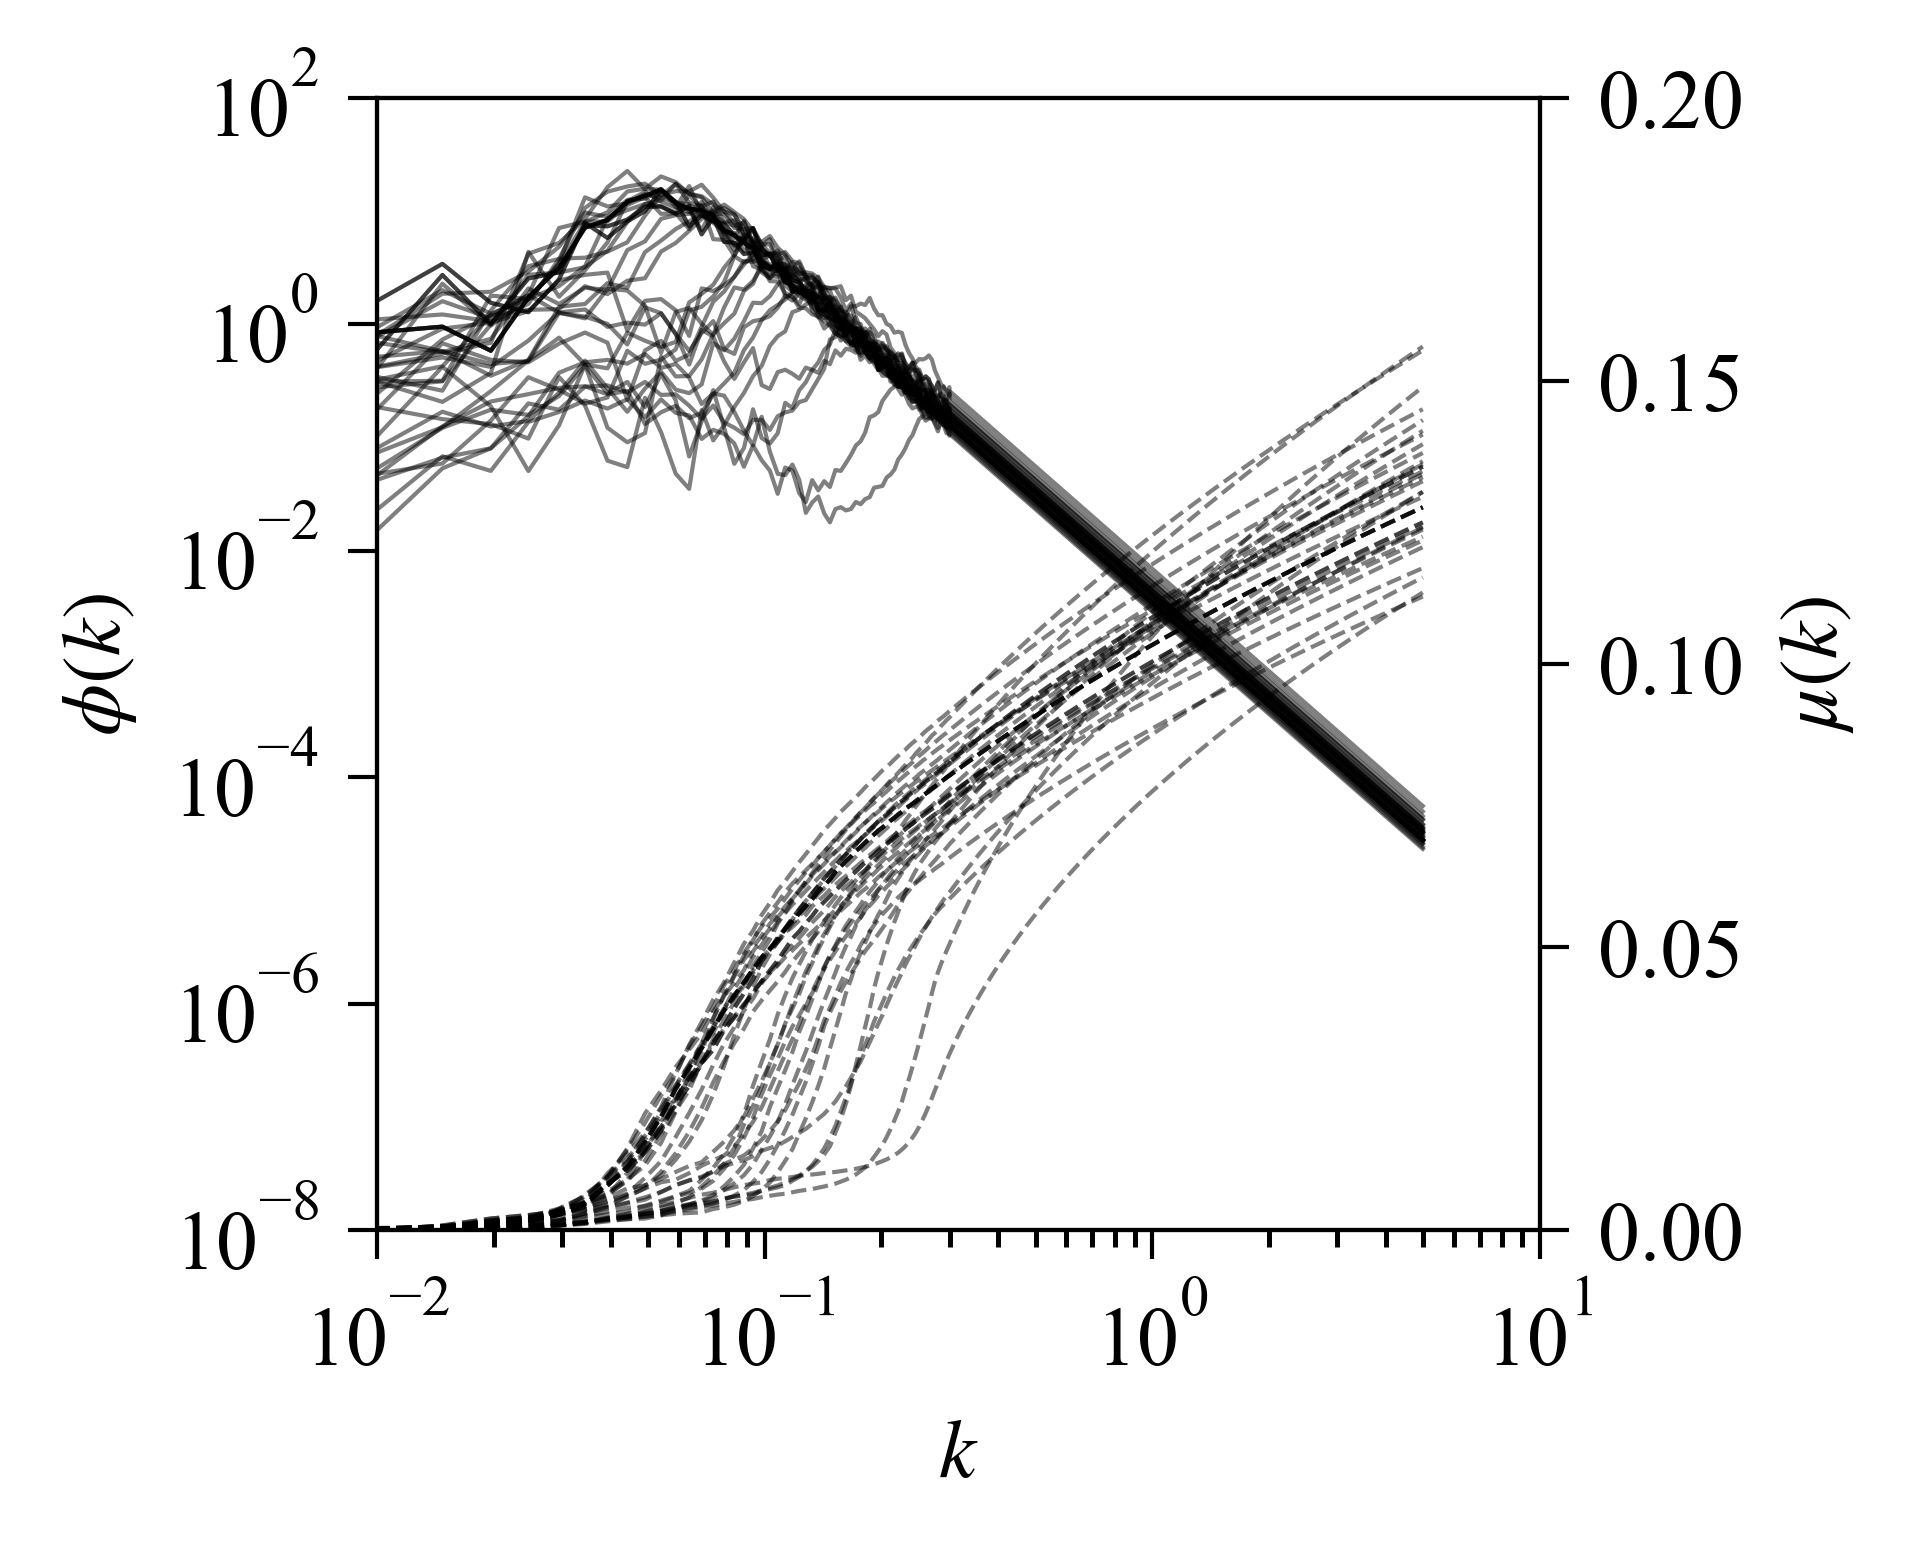

In [35]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()
ax2 = ax.twinx()

for i in range (0,36):
    mu, Hs = steepness_trunc_non_uniform (JK_ensem[i]['phi'], JK_ensem[i]['k'])
    ax.plot(JK_ensem[i]['k'][1:], JK_ensem[i]['phi'][1:], c='k', alpha=0.5, lw=0.5)
    ax2.plot(JK_ensem[i]['k'][1:], mu[1:], '--',  c='k', alpha=0.5, lw=0.5)
    JK_ensem[i]['sigma_trunc'] = mu[-1] # Update mu with the added tail
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.01,10]) 
ax.set_ylim([10**(-8.),10**(2.)])
ax2.set_ylim([0,0.2])
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\phi(k)$')
ax2.set_ylabel(r'$\mu(k)$')

In [35]:
sigma = [data['sigma_trunc'] for data in JK_ensem]
print(np.array(sigma).max(), np.array(sigma).min())

0.1560854215076313 0.11191848149366151


Text(0, 0.5, '$\\Lambda(c) (m^{-2}s)$')

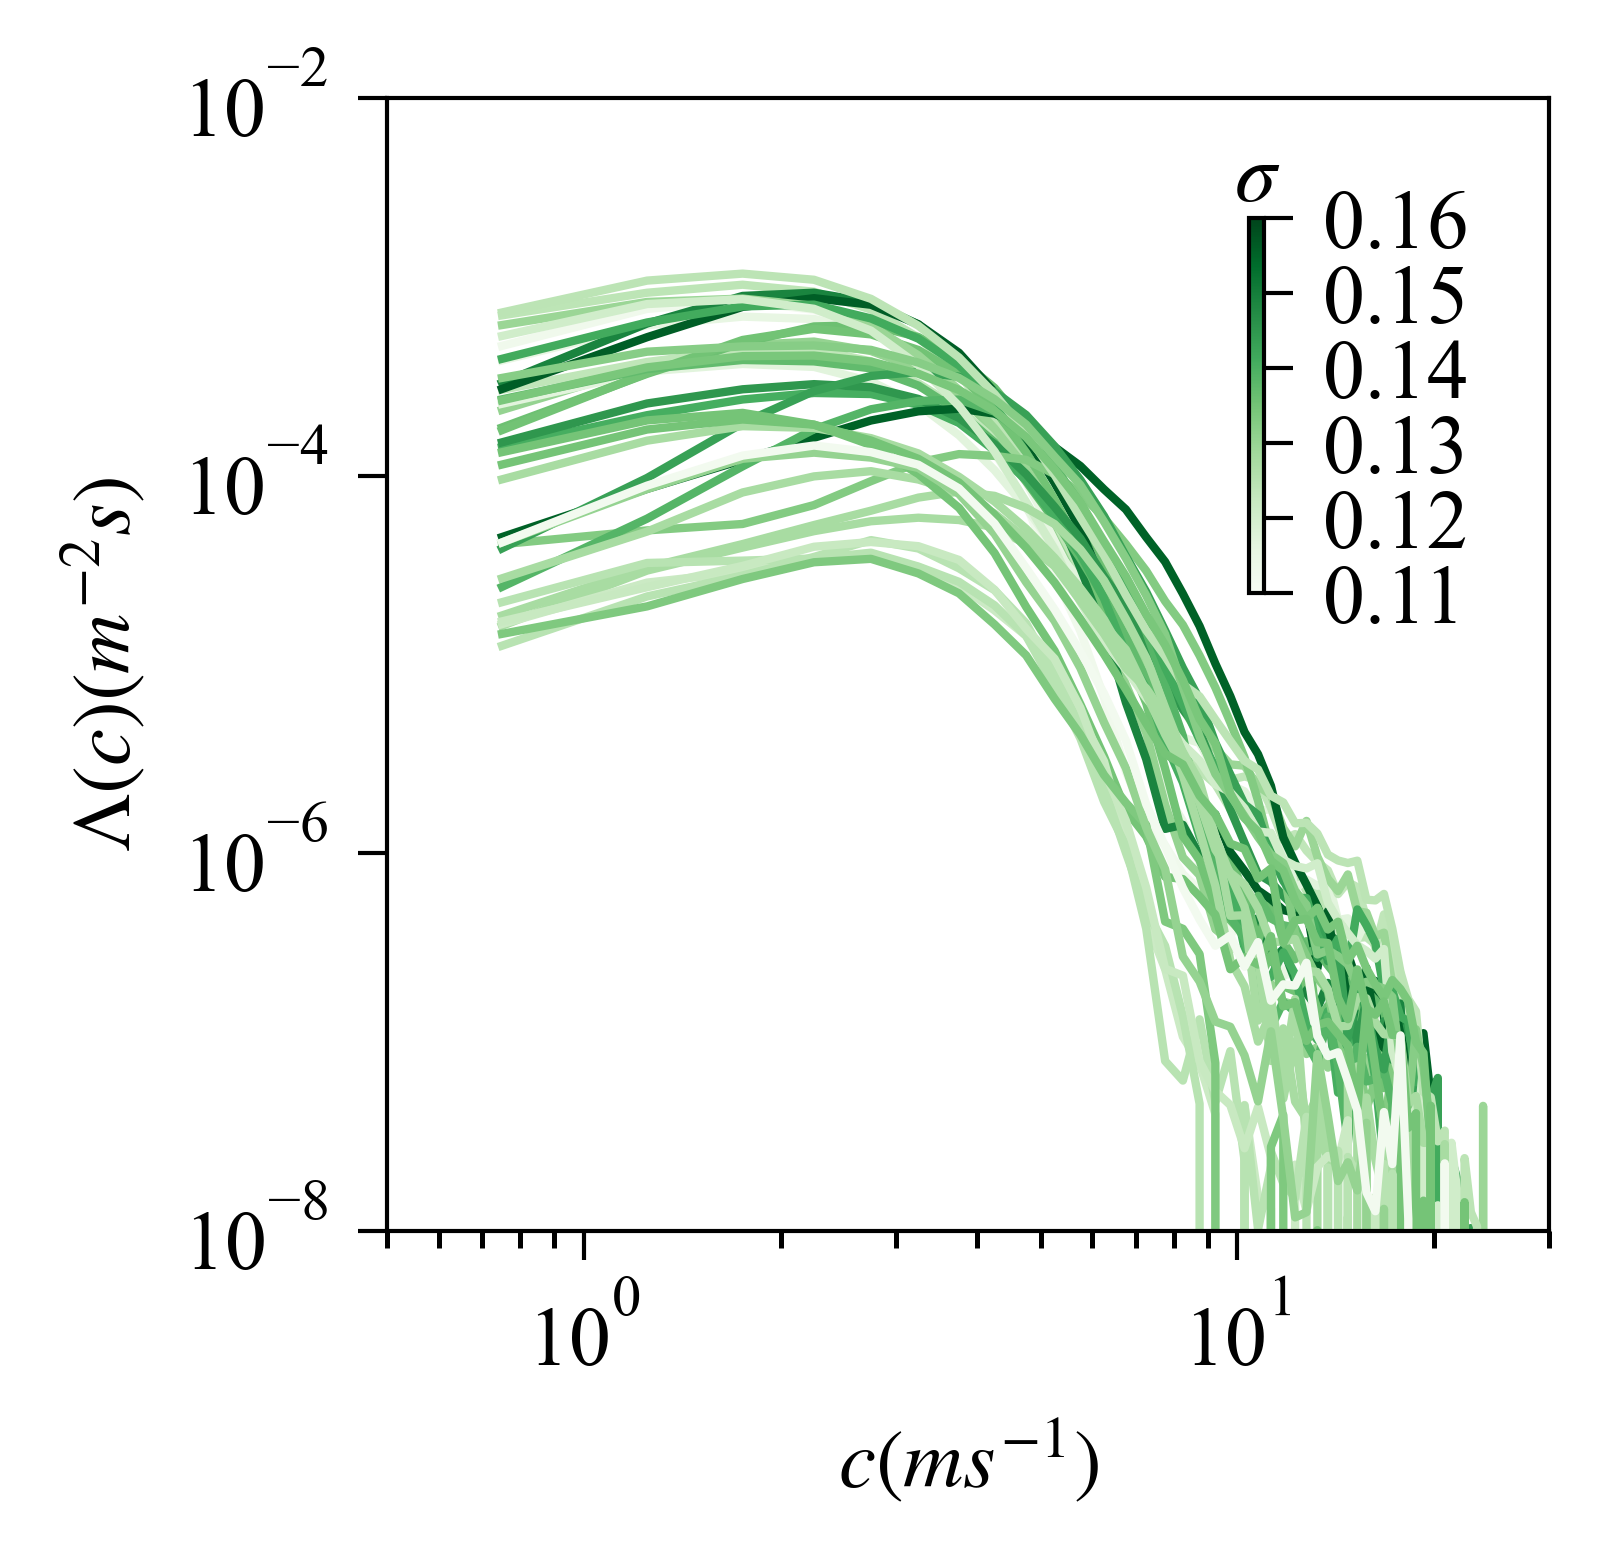

In [36]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()

for i in range (0,36):
    color = plt.get_cmap('Greens')((JK_ensem[i]['sigma_trunc']-0.11)/(0.16-0.11))
    ax.plot(JK_ensem[i]['c'][1:], JK_ensem[i]['L'][1:], c=color, lw=1)
    
ax2  = fig.add_axes([0.7,0.55,0.01,0.25])
norm = mpl.colors.Normalize(vmin=0.11,vmax=0.16)
cbar = mpl.colorbar.ColorbarBase(ax2,cmap=plt.get_cmap('Greens'),norm=norm,orientation='vertical',ticks=(0.11,0.12,0.13,0.14,0.15,0.16))
cbar.ax.text(0.5, 1.1, r'$\sigma$', ha='center', va='center', transform=cbar.ax.transAxes)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.5,30]) 
ax.set_ylim([10**(-8.),10**(-2.)])
ax.set_xlabel(r'$c(m s^{-1})$')
ax.set_ylabel(r'$\Lambda(c) (m^{-2}s)$')

In [37]:
CU_ensem = np.zeros(36)
for i in range (0,36):
    if (np.isnan(JK_add.cp[i]) == False):
        CU = JK_add.cp[i]/JK_add.ustar[i]
        CU_ensem[i] = CU

print(np.array(CU_ensem).max(), np.array(CU_ensem[np.nonzero(CU_ensem)]).min())

9.750681748027674 4.374113723812936


Text(0, 0.5, '$\\Lambda(c) (m^{-2}s)$')

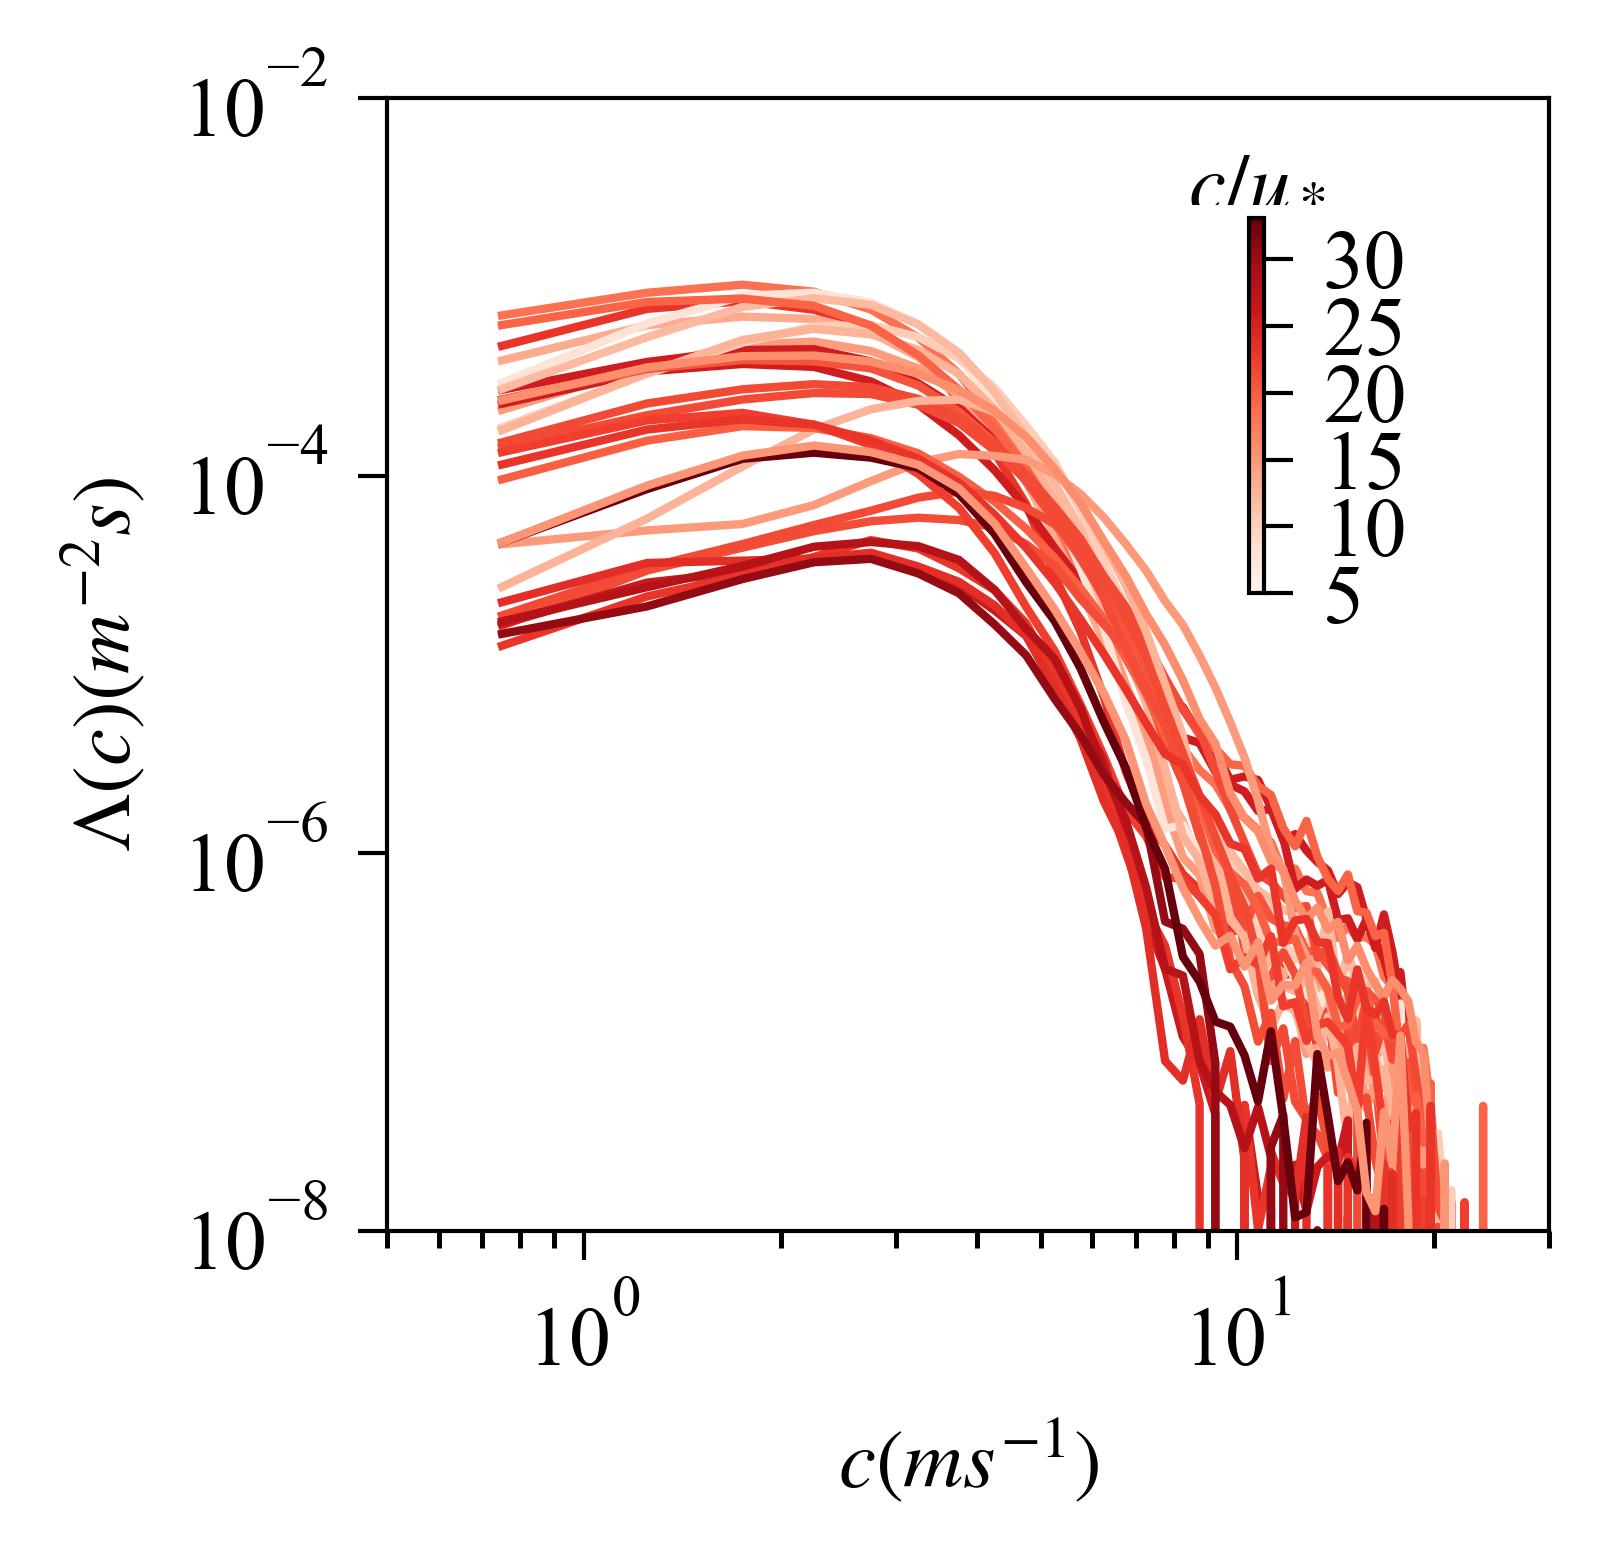

In [47]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()

for i in range (0,36):
    if (np.isnan(s10_add.cp[i]) == False):
        color = plt.get_cmap('Reds')((CU_ensem[i]-5)/(33-5))
        ax.plot(JK_ensem[i]['c'][1:], JK_ensem[i]['L'][1:], c=color, lw=1)
    
ax2  = fig.add_axes([0.7,0.55,0.01,0.25])
norm = mpl.colors.Normalize(vmin=5,vmax=33)
cbar = mpl.colorbar.ColorbarBase(ax2,cmap=plt.get_cmap('Reds'),norm=norm,orientation='vertical',ticks=(5,10,15,20,25,30))
cbar.ax.text(0.5, 1.1, r'$c/u_*$', ha='center', va='center', transform=cbar.ax.transAxes)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.5,30]) 
ax.set_ylim([10**(-8.),10**(-2.)])
ax.set_xlabel(r'$c(m s^{-1})$')
ax.set_ylabel(r'$\Lambda(c) (m^{-2}s)$')

[9]
[32]
[27]
[18]
[13]
[13]
[53]
[26]
[19]
[17]
[11]
[8]
[9]
[10]
[12]
[12]
[23]
[31]
[37]
[20]
[22]
[15]
[13]
[10]
[10]
[10]
[10]
[10]
[10]
[9]
[12]
[12]
[10]
[9]
[6]
[27]


Text(0, 0.5, '$\\phi(k)(m^3)$')

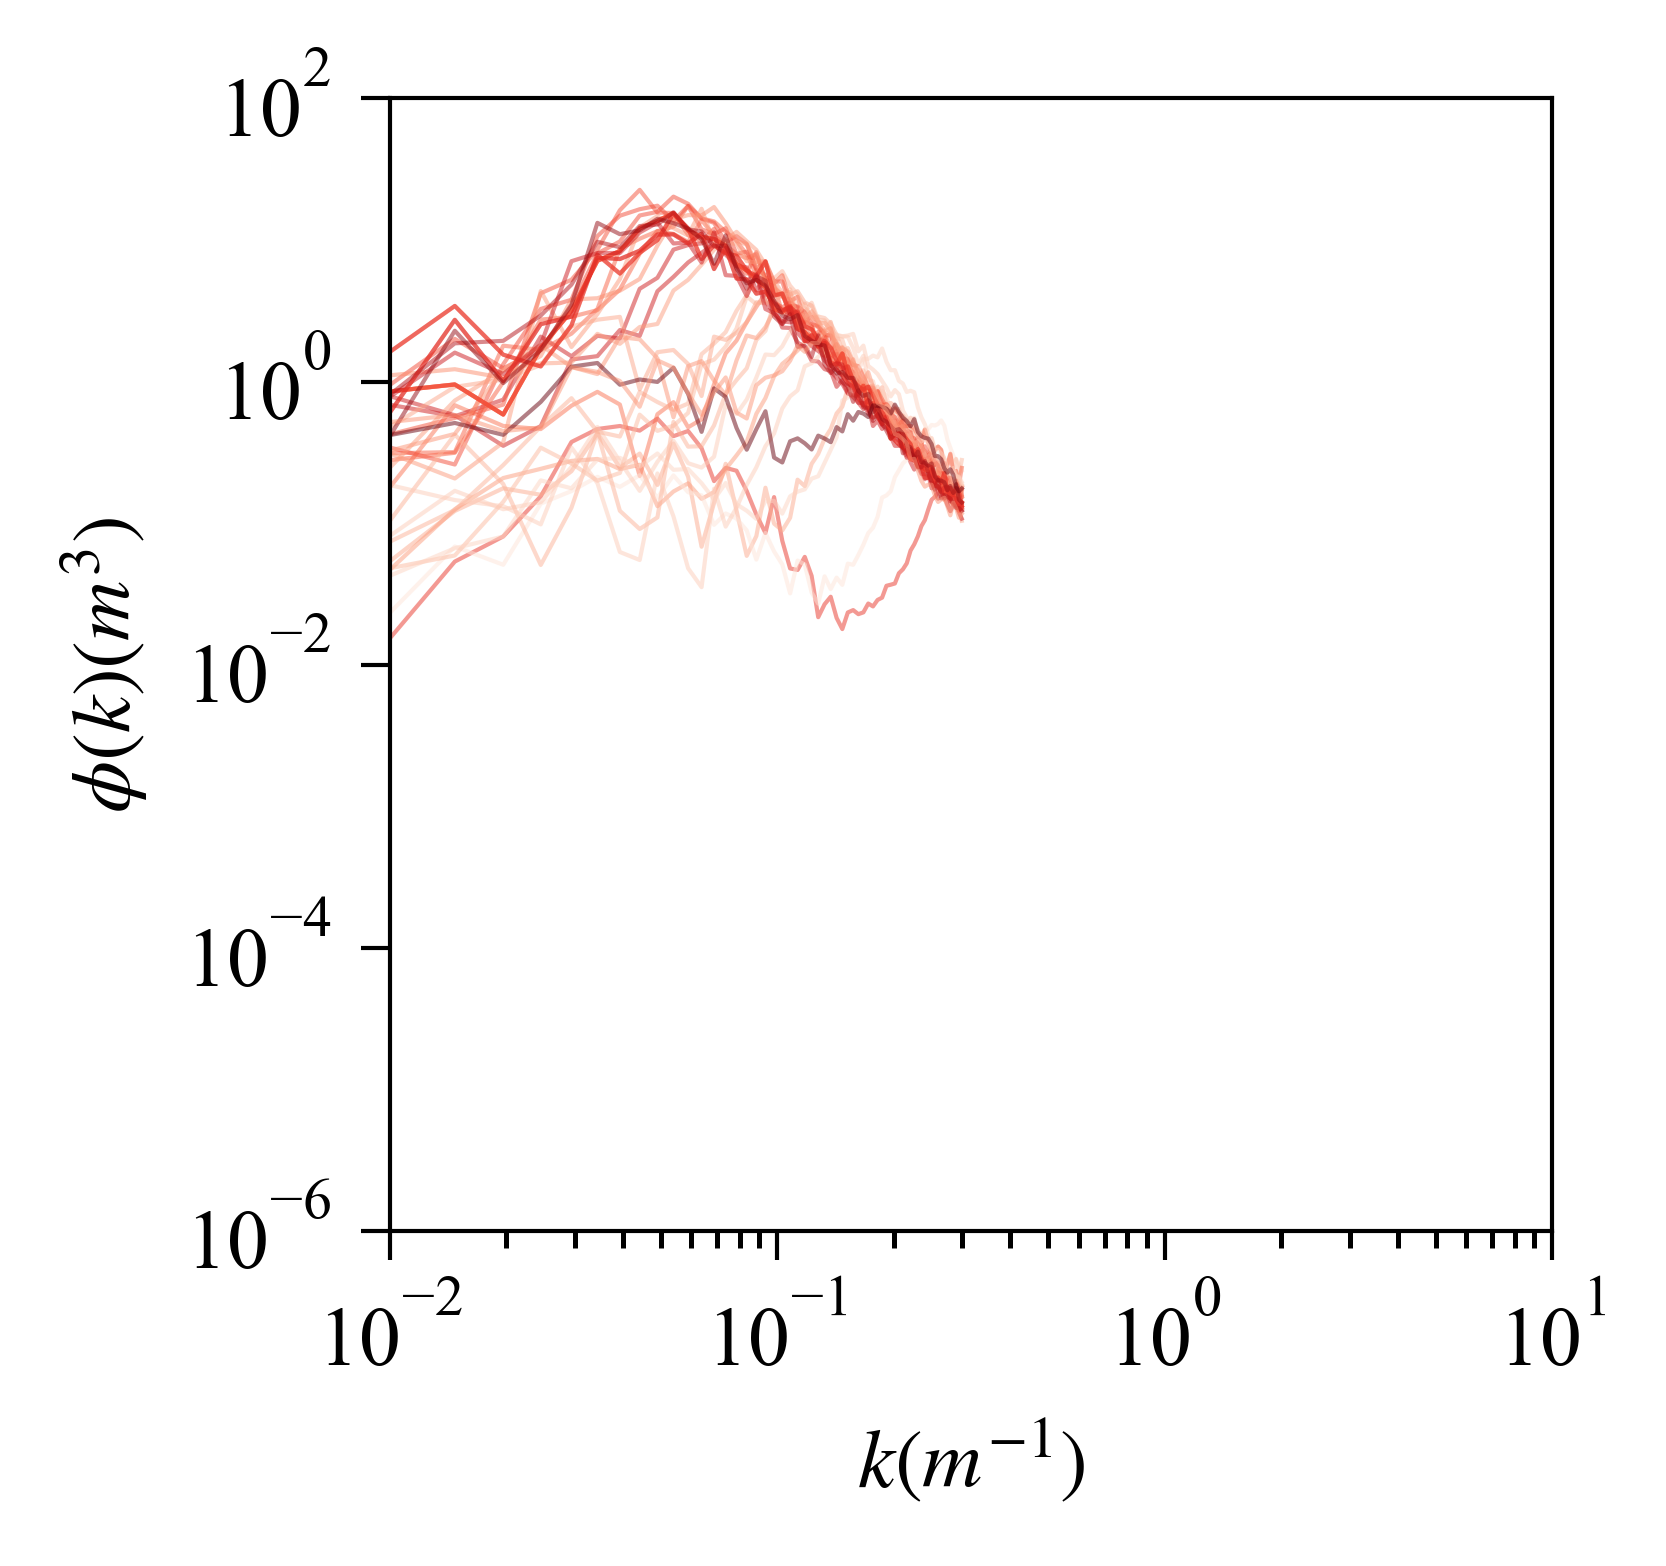

In [50]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()
# ax2 = ax.twinx()

JK_ensem = []
for i in range (0,36):
    JK_spec = pd.read_csv('data/JK_36/spec_%g.txt' %(i+1), delimiter = ',')
    JK_Lc = pd.read_csv('data/JK_36/lambda_%g.txt' %(i+1), delimiter = ',')
    mu, Hs = steepness_trunc_non_uniform (JK_spec.Eom, JK_spec.k)
    color = plt.get_cmap('Reds')((CU_ensem[i]-5)/(33-5))
    ax.plot(JK_spec.k[1:], JK_spec.Eom[1:], c=color, alpha=0.5, lw=0.5)
    index = np.where(JK_spec.Eom == np.max(JK_spec.Eom))[0]
    print(index)
#     ax.axvline(x=9.8/JK_add.cp[i]**2, c='b', alpha = 0.5, lw=1)
#     ax.axvline(x=JK_spec.k[index[0]], c='r', alpha = 0.5, lw=1)
    indices = [idx for idx,val in enumerate(JK_spec.k) if val < 5]
    data = {"sigma_trunc": mu[indices[-1]], "k": JK_spec.k, "phi": JK_spec.Eom, "c": JK_Lc.c, "L": JK_Lc.Lambda, "cp": (9.8/JK_spec.k[index[0]])**0.5}
    JK_ensem.append(data)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.01,10]) 
ax.set_ylim([10**(-6.),10**(2.)])
# ax2.set_ylim([0,0.2])
ax.set_xlabel(r'$k(m^{-1})$')
ax.set_ylabel(r'$\phi(k)(m^3)$')
# ax2.set_ylabel(r'$\mu(k)$')

In [ ]:
# How to speed up matplotlib
# https://stackoverflow.com/questions/8955869/why-is-plotting-with-matplotlib-so-slow
from matplotlib import animation
from visualization import contour
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.image as mpimg

# Single animation generation function
def plot_animation(animate_function, frame_number = 31, interval_time = 100):

    # First set up the figure, the axis, and the plot element we want to animate   
    fig, (ax1,ax2) = plt.subplot(1,2,figsize=[4,2])

    # animation function.  This is called sequentially
    def animate(i):
        imgplot = animate_function(i, ax)
        return imgplot,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, frames=frame_number, interval=interval_time, blit = True)  
    return anim


# Define the function called at every animation time to read in images
def plot_func(i, ax):

    return image

anim = plot_animation(plot_func, frame_number = 20, interval_time = 100) # Specify frame number
HTML(anim.to_html5_video())

In [42]:
CU_ensem = np.zeros(36)
for i in range (0,36):
    if (np.isnan(JK_add.cp[i]) == False):
        CU = JK_ensem[i]['cp']/JK_add.ustar[i]
        CU_ensem[i] = CU
print(np.array(CU_ensem).max(), np.array(CU_ensem[np.nonzero(CU_ensem)]).min())

33.83258028156899 7.903430995970979


0.11264477472931547
3.45121932698432 14.1295421233129
0.11530049791815165
3.62668546426041 7.778056947797032
0.13040755153506314
4.31633717654202 8.444016491289519
0.12414647909455245
3.99262644557121 10.250647235392492
0.11695358575689024
3.51584118644676 11.941642642883696
0.12374479478482148
3.45064717867853 11.941642642883696
0.14894829741654633
3.72358242048283 6.080386814791891
0.13583086793434884
4.24287726438082 8.598965497953252
0.1560854215076313
4.35 9.991095050455522
0.13530966886188628
4.07829469810384 10.531538892891453
0.12953456691463766
3.94798742536091 12.89844824692986
0.13727626199698445
3.44014758337545 14.893845134986815
0.14053641800849676
3.75 14.1295421233129
0.14500520744488996
3.62571942339681 13.471989817748575
0.1553995095542451
3.75660203072978 12.392428228388043
0.13300666097543706
4.84308105884768 12.392428228388043
0.13883365568580255
3.55068302370789 9.120580222187849
0.14308265313942076
3.3128017912337 7.89865416966858
0.14121731041168079
4.0146950921

Text(0, 0.5, '$\\Lambda(c) (c_p^3g^{-1}\\sigma^{-2})$')

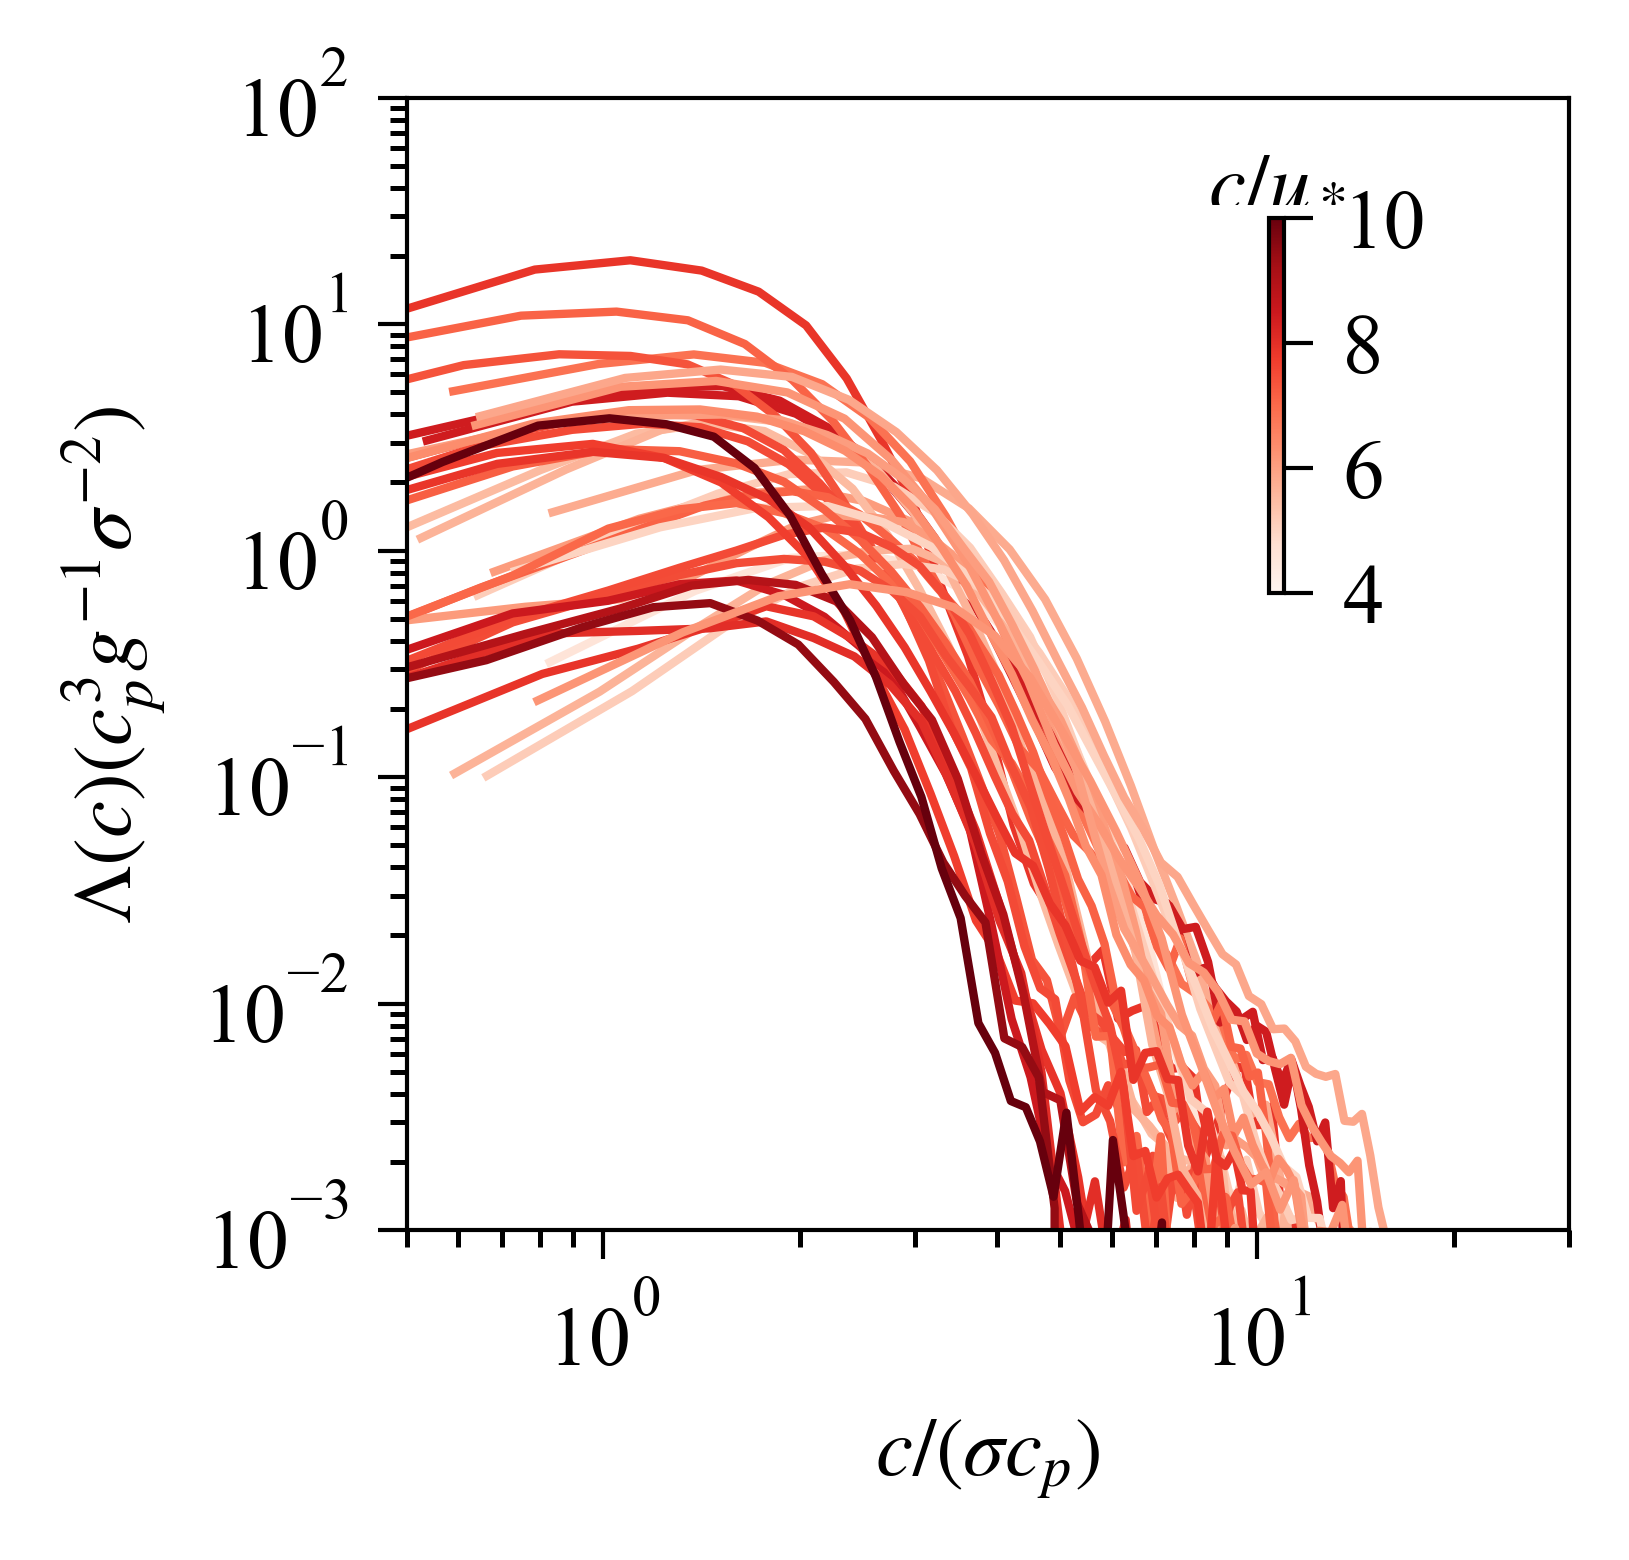

In [44]:
""" Use cp reported by the campaign vs cp from the spectrum """ 
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()

for i in range (0,36):
    if (np.isnan(JK_add.cp[i]) == False):
        color = plt.get_cmap('Greens')((JK_ensem[i]['sigma_trunc']-0.11)/(0.16-0.11))
        color = plt.get_cmap('Reds')((CU_ensem[i]-5)/(33-5))
        print (JK_ensem[i]['sigma_trunc'])
        """ cp from dataset """
#         c_hat = JK_ensem[i]['c'][1:]/(JK_add.cp[i]*JK_ensem[i]['sigma_trunc'])
#         print (JK_add.cp[i])
#         lambdac_hat = JK_ensem[i]['L'][1:]*JK_add.cp[i]**3/9.8/JK_ensem[i]['sigma_trunc']**2
#         sigma = JK_ensem[i]['sigma_trunc']
#         ax.plot(c_hat, lambdac_hat, c=color, lw=1)       
        c_hat = JK_ensem[i]['c'][1:]/(JK_ensem[i]['cp']*JK_ensem[i]['sigma_trunc'])
        print (JK_add.cp[i], JK_ensem[i]['cp'])
        lambdac_hat = JK_ensem[i]['L'][1:]*JK_ensem[i]['cp']**3/9.8/JK_ensem[i]['sigma_trunc']**2
        sigma = JK_ensem[i]['sigma_trunc']
        ax.plot(c_hat, lambdac_hat, c=color, lw=1)

        file = open("./data/JK_36/Newscaling_JK36_%d.csv" %(i+1), "w")
        fieldnames = ['hat{c}', 'hat{Lambda(c)}', 'sigma']
        writer = csv.writer(file)
        writer.writerow(fieldnames) 
        for c, lambdac in zip(c_hat, lambdac_hat):
            writer.writerow([round(c, 3), round(lambdac, 6), round(JK_ensem[i]['sigma_trunc'], 4)])           
        file.close()  
        ax.set_xscale('log')
        ax.set_yscale('log')
        
ax2  = fig.add_axes([0.7,0.55,0.01,0.25])
norm = mpl.colors.Normalize(vmin=4,vmax=10)
cbar = mpl.colorbar.ColorbarBase(ax2,cmap=plt.get_cmap('Reds'),norm=norm,orientation='vertical',ticks=(4,6,8,10))
cbar.ax.text(0.5, 1.1, r'$c/u_*$', ha='center', va='center', transform=cbar.ax.transAxes)

        
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.5,30]) 
ax.set_ylim([10**(-3.),10**(2)])
ax.set_xlabel(r'$c/(\sigma c_p)$')
ax.set_ylabel(r'$\Lambda(c) (c_p^3g^{-1}\sigma^{-2})$')

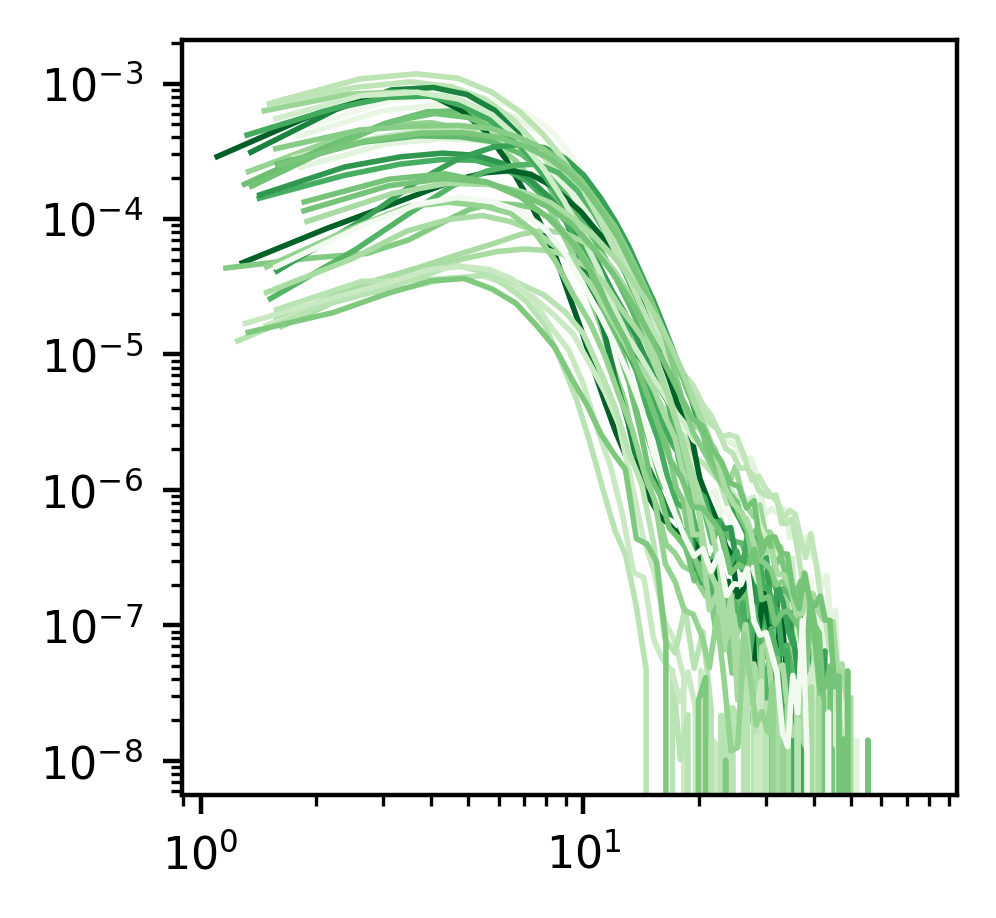

In [130]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()

for i in range (0,36):
    if JK_add.cp[i] != 'nan':
        color = plt.get_cmap('Greens')((JK_ensem[i]['sigma_trunc']-0.11)/(0.16-0.11))
        ax.plot(JK_ensem[i]['c'][1:]/(JK_add.cp[i]*JK_ensem[i]['sigma_trunc']), JK_ensem[i]['L'][1:], c=color, lw=1)
        
        c_hat = JK_ensem[i]['c'][1:]/(JK_add.cp[i]*JK_ensem[i]['sigma_trunc'])
        lambdac_hat = r09_ensem[i]['L'][1:]*r09_add.cp[i]**3/9.8/r09_ensem[i]['sigma_trunc']**2
        sigma = r09_ensem[i]['sigma_trunc']
        ax.plot(c_hat, lambdac_hat, c=color, lw=1)

        file = open("./data/JK_36/Newscaling_JK36_%d.csv" %(i+1), "w")
        fieldnames = ['hat{c}', 'hat{Lambda(c)}', 'sigma']
        writer = csv.writer(file)
        writer.writerow(fieldnames) 
        for c, lambdac in zip(c_hat, lambdac_hat):
            writer.writerow([round(c, 3), round(lambdac, 6), round(s10_ensem[i]['sigma_trunc'], 4)])           
        file.close()  
        ax.set_xscale('log')
        ax.set_yscale('log')
        
#         ax.set_xlim([0.1,10]) 
#         ax.set_ylim([10**(-5.),10**(1.)])

In [122]:
sigma = [data['sigma_trunc'] for data in JK_ensem]
print(np.array(sigma).max(), np.array(sigma).min())

0.09169635712368007 0.03105907137962934


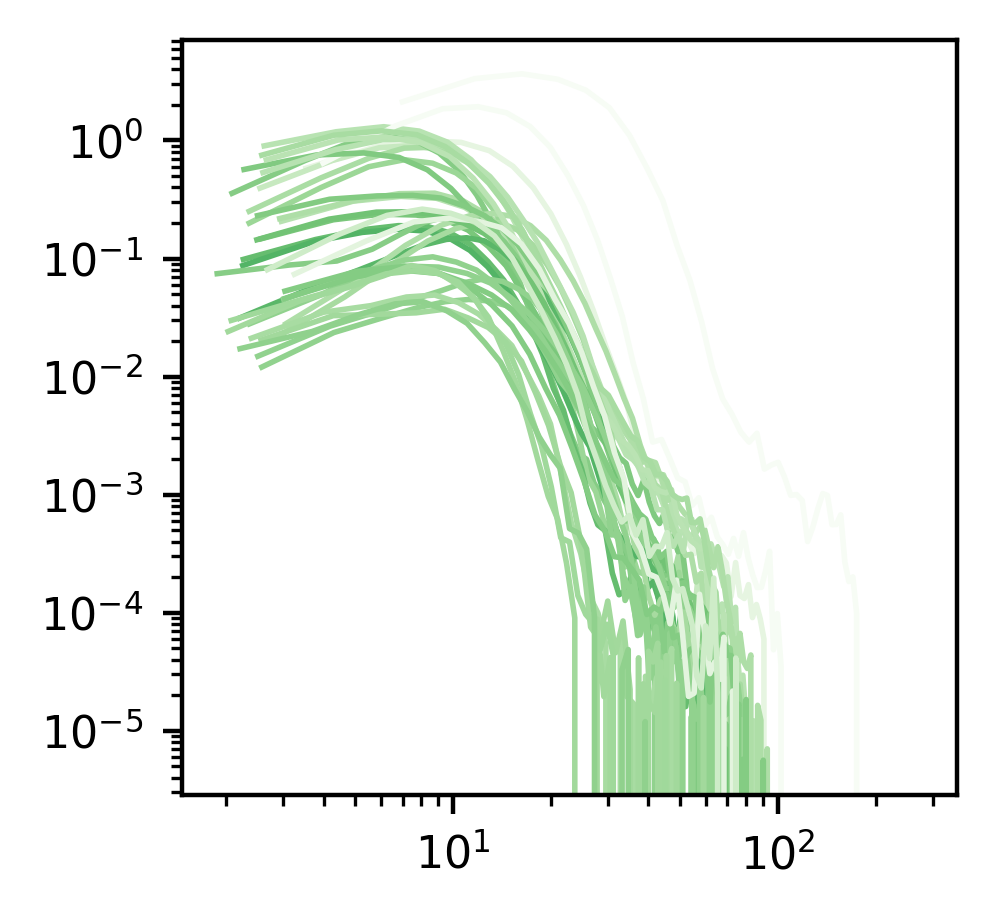

In [121]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()

for i in range (0,36):
    if JK_add.cp[i] != 'nan':
        color = plt.get_cmap('Greens')((JK_ensem[i]['sigma_trunc']-0.05)/(0.122-0.05))
        ax.plot(JK_ensem[i]['c'][1:]/(JK_add.cp[i]*JK_ensem[i]['sigma_trunc']), JK_ensem[i]['L'][1:]*JK_add.cp[i]**3/9.8/JK_ensem[i]['sigma_trunc']**2, c=color, lw=1)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim([0.1,10]) 
# ax.set_ylim([10**(-1.),10**(5.)])

In [ ]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()

for i in range (0,36):
    if JK_add.cp[i] != 'nan':
        color = plt.get_cmap('Greens')((JK_ensem[i]['sigma_trunc']-0.05)/(0.1-0.05))
        ax.plot(JK_ensem[i]['c'][1:]/(JK_add.cp[i]*JK_ensem[i]['sigma_trunc']), JK_ensem[i]['L'][1:], c=color, lw=1)
        ax.set_xscale('log')
        ax.set_yscale('log')
#         ax.set_xlim([0.1,10]) 
#         ax.set_ylim([10**(-5.),10**(1.)])

Text(0, 0.5, '$\\mu(k)$')

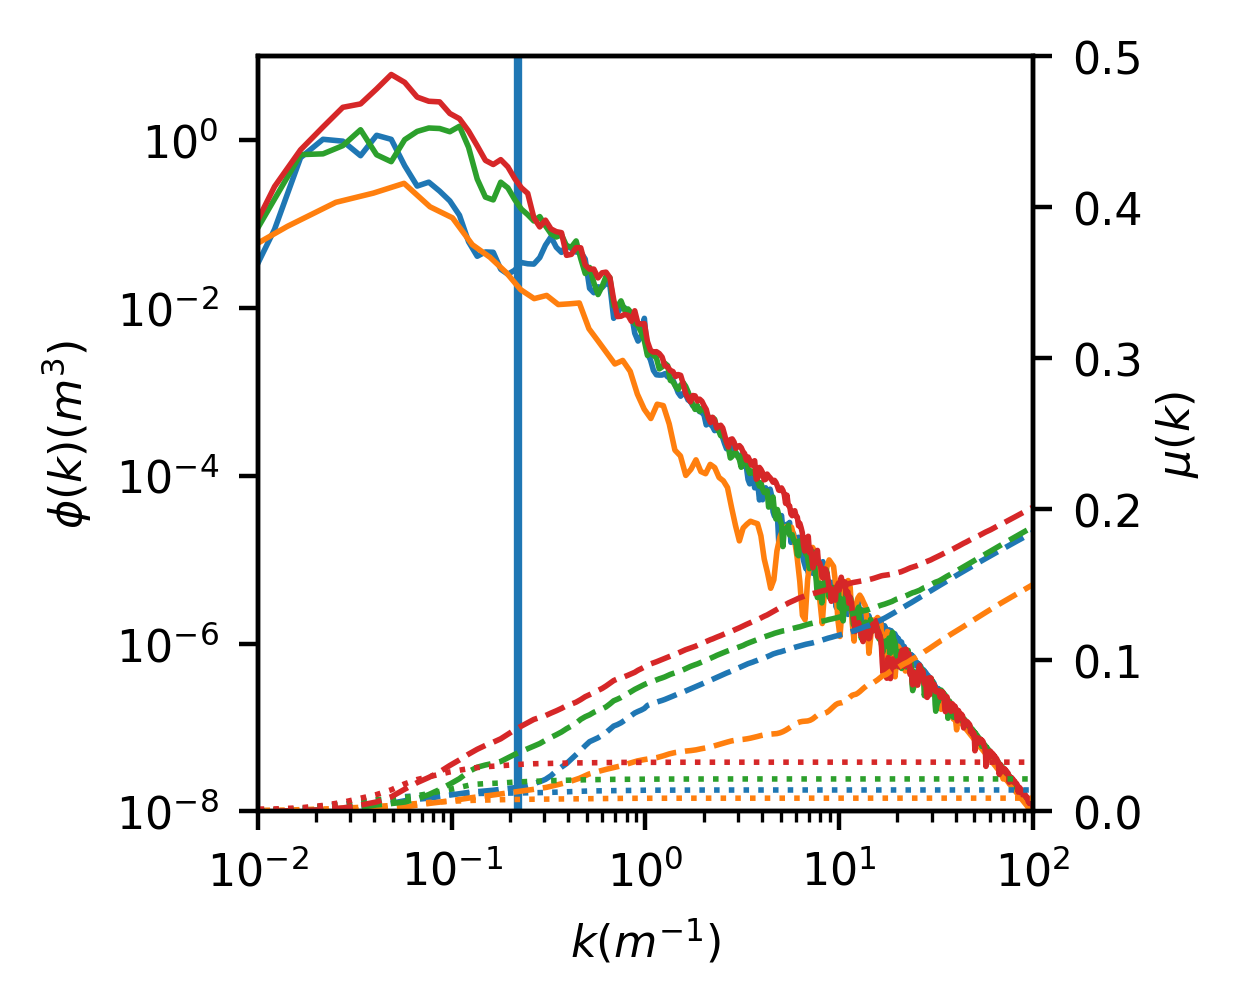

In [8]:
fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()
ax2 = ax.twinx()

s10_spec1 = pd.read_csv('data/matlab/s10_spec1.csv', delimiter = ',')
mu, Hs = steepness_trunc_non_uniform (s10_spec1.S, s10_spec1.k)
ax.plot(s10_spec1.k[1:], s10_spec1.S[1:], c='C0', lw=1)

ax.axvline(x=0.22058956)
ax2.plot(s10_spec1.k[1:], mu[1:]**0.5, '--',  c='C0', lw=1)
ax2.plot(s10_spec1.k[1:], Hs[1:]*0.05, ':',  c='C0', lw=1)

s10_spec39 = pd.read_csv('data/matlab/s10_spec39.csv', delimiter = ',')
mu, Hs = steepness_trunc_non_uniform (s10_spec39.S, s10_spec39.k)
ax.plot(s10_spec39.k[1:], s10_spec39.S[1:], c='C1', lw=1)
ax2.plot(s10_spec39.k[1:], mu[1:]**0.5, '--',  c='C1', lw=1)
ax2.plot(s10_spec39.k[1:], Hs[1:]*0.05, ':',  c='C1', lw=1)

r09_spec1 = pd.read_csv('data/matlab/r09_spec1.csv', delimiter = ',')
mu,Hs = steepness_trunc_non_uniform (r09_spec1.S, r09_spec1.k)
ax.plot(r09_spec1.k[1:], r09_spec1.S[1:], c='C2', lw=1)
ax2.plot(r09_spec1.k[1:], mu[1:]**0.5, '--',  c='C2', lw=1)
ax2.plot(r09_spec1.k[1:], Hs[1:]*0.05, ':',  c='C2', lw=1)

r09_spec25 = pd.read_csv('data/matlab/r09_spec25.csv', delimiter = ',')
mu, Hs = steepness_trunc_non_uniform (r09_spec25.S, r09_spec25.k)
ax.plot(r09_spec25.k[1:], r09_spec25.S[1:], c='C3', lw=1)
ax2.plot(r09_spec25.k[1:], mu[1:]**0.5, '--',  c='C3', lw=1)
ax2.plot(r09_spec25.k[1:], Hs[1:]*0.05, ':',  c='C3', lw=1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.01,100])
ax.set_ylim([10**(-8.),10**(1.)])
Hs = np.sum(s10_spec1.S*s10_spec1.k[1:])
ax2.set_ylim([0,0.5])
ax.set_ylabel('$\phi(k)(m^3)$')
ax.set_xlabel('$k(m^{-1})$')
ax2.set_ylabel('$\mu(k)$', labelpad=2)

### Comparison with field measurements (from GOTEX campaign)

In [9]:
""" Data from Jessica Kleiss GOTEX campaign """
WCC_JK = pd.read_csv('data/matlab/WCC_JK.txt', delimiter = ',')
# WCC_JK = WCC_JK.dropna()

In [10]:
def steepness_trunc_non_uniform (F,k):
    mu = np.zeros(len(k))
    Hs = np.zeros(len(k))
    dk = np.roll(k, -1) - k
    dk = np.array(dk); dk[-1]=0
    for i,k_ in enumerate(k):
        mu[i] = np.sum(k[:i]**2*F[:i]*dk[:i])**0.5
        Hs[i] = np.sum(F[:i]*dk[:i])**0.5
    return mu, Hs

In [11]:
from os.path import exists
sigma_ensem = []
WCC_ensem = []
Hs1_ensem = [] # Hs from matlab
Hs2_ensem = [] # Hs from spectrum
kp_ensem = []
for i in range(1,341):
    if exists('data/WCC_JK_spec/spec_%g.txt' %i):
        spec = pd.read_csv('data/WCC_JK_spec/spec_%g.txt' %i, delimiter = ',')
        mu, Hs = steepness_trunc_non_uniform (spec.Eom,spec.k)
        sigma = mu[-1]
        sigma_ensem.append(sigma)
        WCC_ensem.append(WCC_JK.WCC[i-1])
        Hs1_ensem.append(WCC_JK.Hs[i-1])
        Hs2_ensem.append(Hs[-1])
        kp_ensem.append(WCC_JK.kp[i-1])

Text(0, 0.5, '$\\phi(k)(m^{3})$')

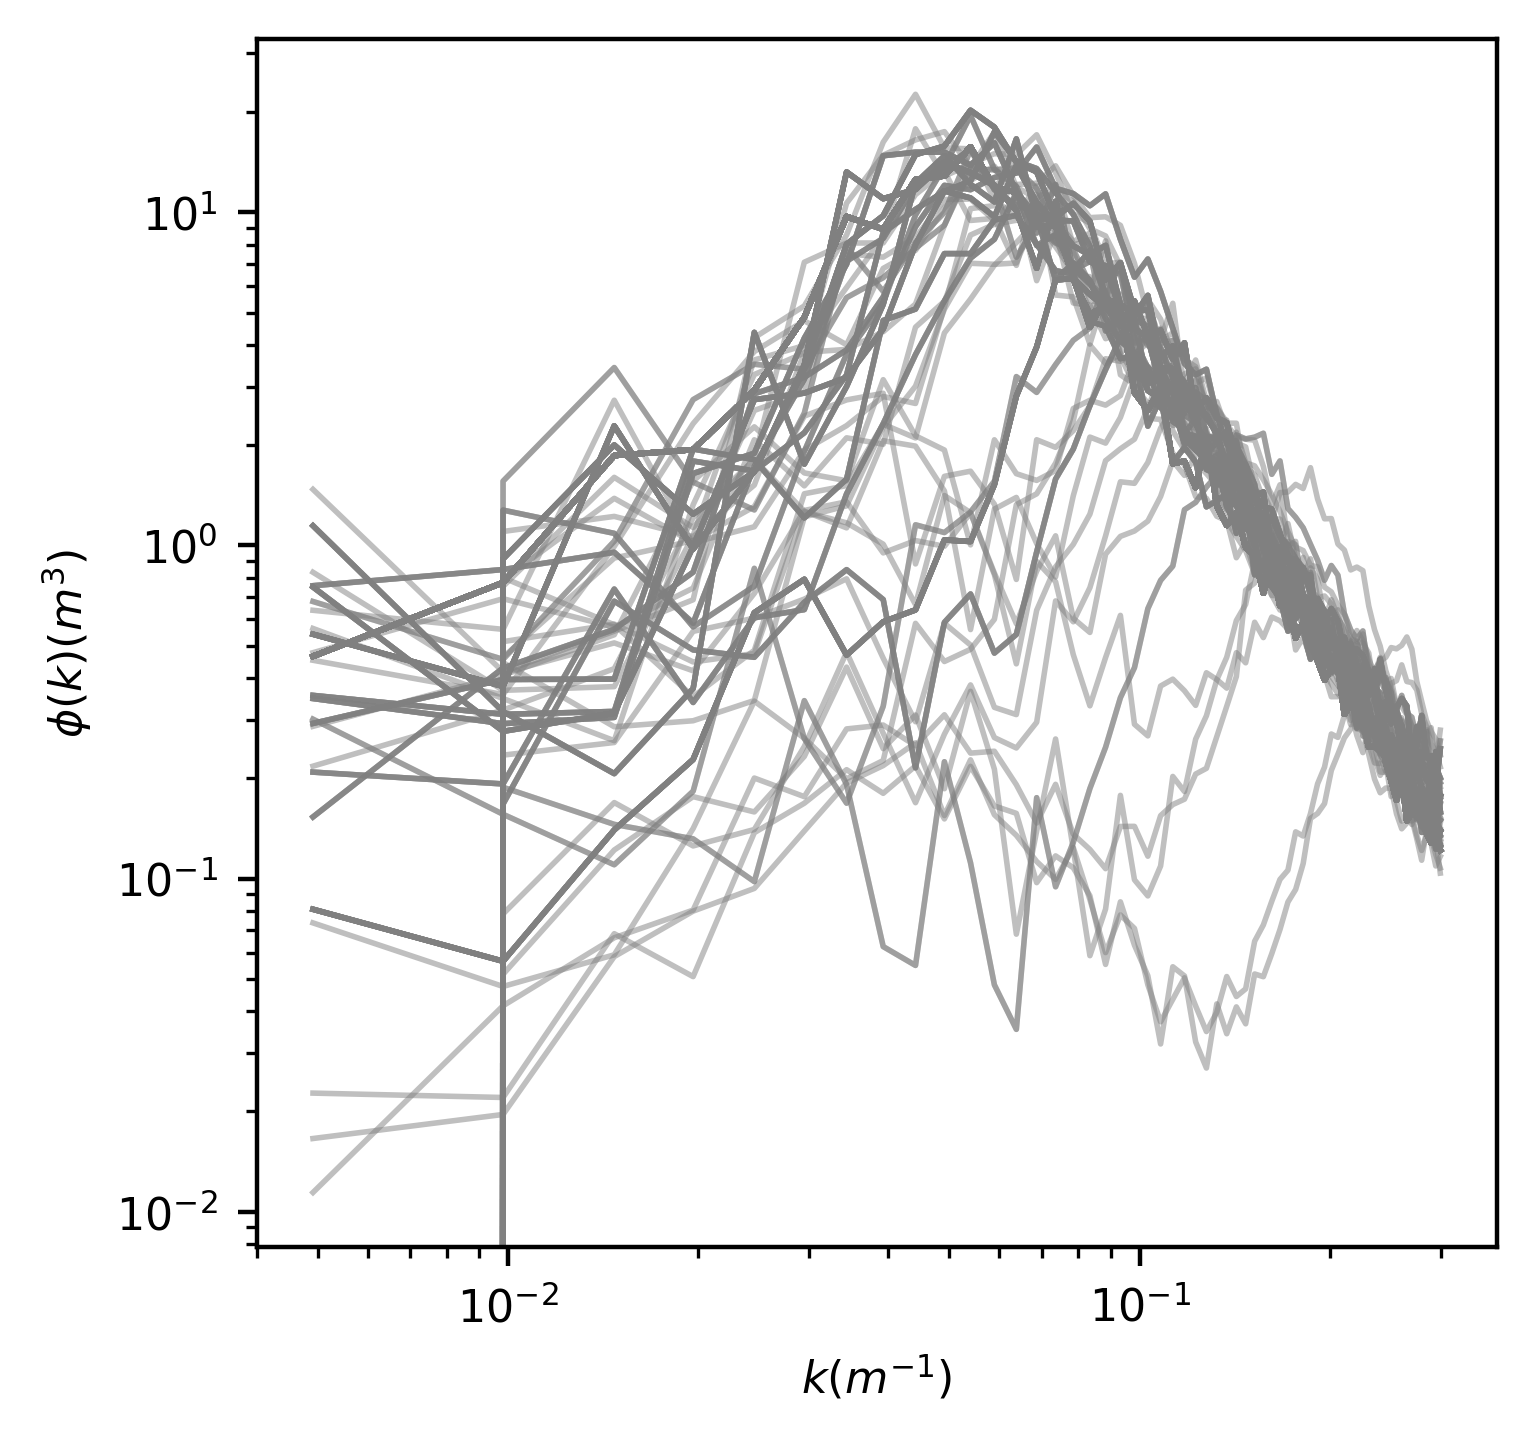

In [12]:
for i in range(1,341):
    if exists('data/WCC_JK_spec/spec_%g.txt' %i):
        spec = pd.read_csv('data/WCC_JK_spec/spec_%g.txt' %i, delimiter = ',')
        plt.plot(spec.k, spec.Eom, lw=1, alpha=0.5, c='gray')
plt.xscale('log');plt.yscale('log')
plt.xlabel(r'$k(m^{-1})$'); plt.ylabel(r'$\phi(k)(m^{3})$')

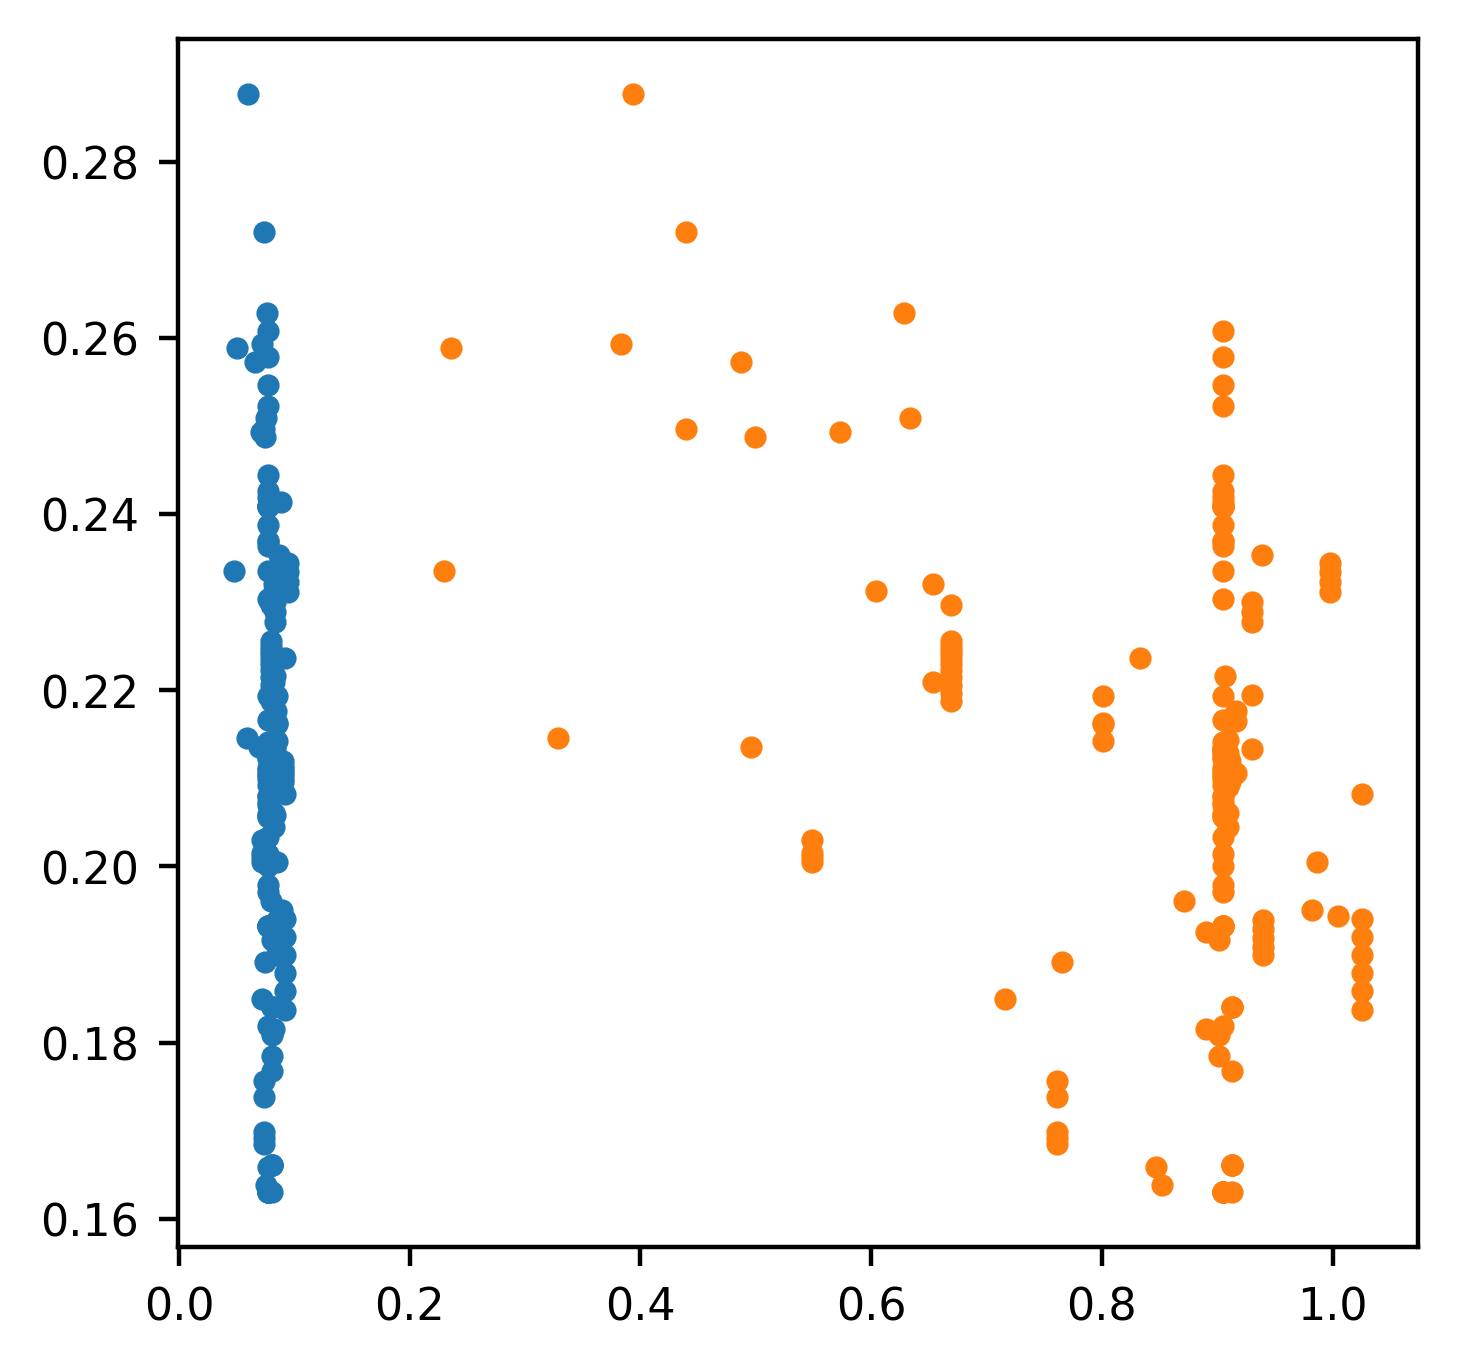

In [13]:
plt.plot(sigma_ensem, np.array(kp_ensem)*np.array(Hs1_ensem), '.')
plt.plot(np.array(Hs2_ensem), np.array(kp_ensem)*np.array(Hs1_ensem), '.')

NameError: name 'config_set' is not defined

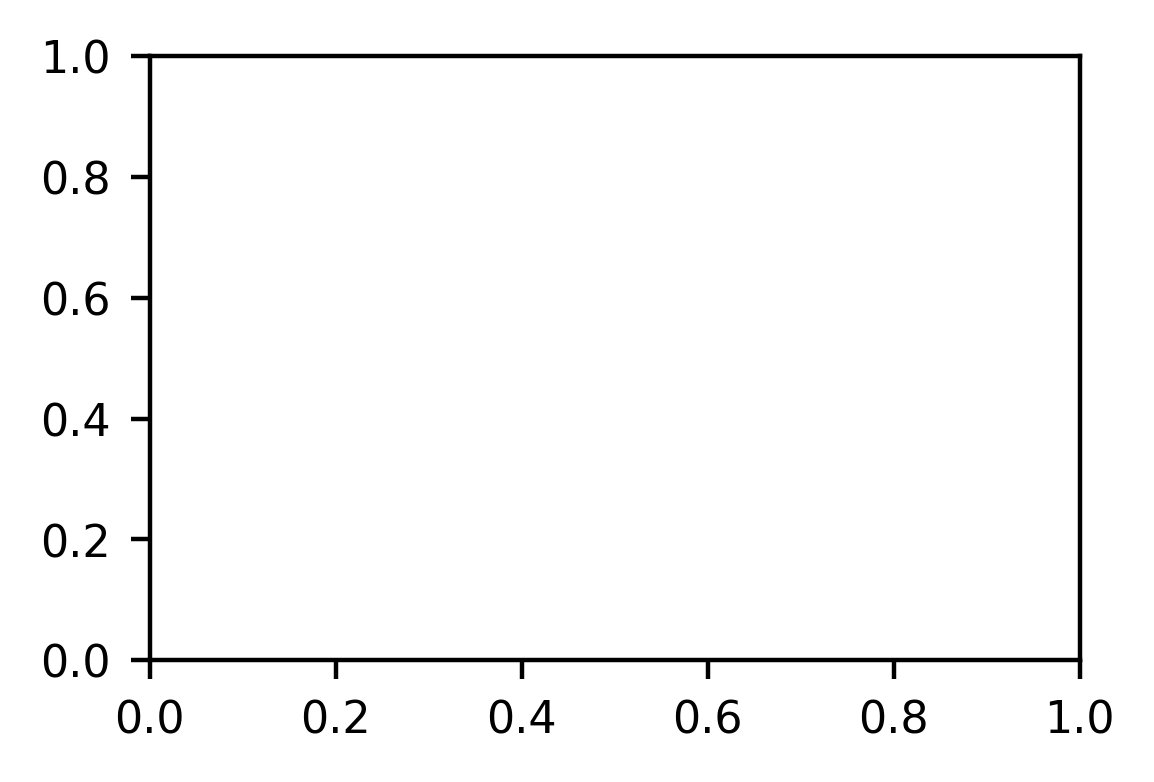

In [14]:
""" Second moment and WCC, as functions of slope 
    NOTE：this needs the functions from Stat """
fig = plt.figure(figsize=[3,2]); ax = plt.gca()

ensem_WCC = []
ensem_U10 = []

for config in config_set:
    for j, case in enumerate(config.cases):
        if j == 0 and case.config.L0 == 200 :
            hist_aver = np.average(np.array(case.hist_ensem['hist_ensem']), axis=0)
            bins = case.hist_ensem['bins'] 
            bins = bins[1:] - (bins[2] - bins[1])/2
            case.second = 0
    #         case.first = 0 
    #         threshold = 1*(9.8*config.Hskp/config.kp)**0.5   
            for (bin_, hist_) in zip(bins, hist_aver):
                if bin_ > 2: # the 2m/s limit
    #             if bin_ > threshold: # the 2m/s limit
                    case.second += bin_**2*hist_/2**case.LEVEL/case.config.L0/(bins[2] - bins[1])
    #                 case.first += bin_*hist_/2**case.LEVEL/case.config.L0/(bins[2] - bins[1])
            case.second = case.second*(bins[2] - bins[1])

    #         """ Compute U10: first from fetch-limited condition get u*, and then use Charnock relation """
    #         const = 1
    #         config.cp = (9.8/config.kp)**0.5
    #         ustar_P = (config.P*np.exp(-1.25)/0.016/(config.cp**0.53)*9.8**0.5)**(1/0.47)
    #         ustar = const*((config.Hskp/config.kp*9.8)/config.cp**1.5)**2
    #         print(ustar_P, ustar)
    #         U10 = (ustar**2*np.log(10/(0.0112*ustar**2/9.8))**2/0.41**2)**0.5
    # #         U10 = (ustar_P**2*np.log(10/(0.0112*ustar**2/9.8))**2/0.41**2)**0.5 # More noisy!
    #         ensem_U10.append(U10)
    #         gamma = 0.56

#             plt.plot(case.Hskp, case.second*2*np.pi/9.8*0.56*100, c=case.config.cc, marker='^', markersize=4, markerfacecolor='None', markeredgewidth=1)
            plt.plot(case.mu_plateau, case.second*2*np.pi/9.8*0.56*100, c=case.config.cc, marker='^', markersize=4, markerfacecolor='None', markeredgewidth=1)
            ensem_L.append(case.zeroth)
        
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="plain", scilimits=(0,0))

# slope = (ensem_dEdt[-1] - ensem_dEdt[0])/(ensem_fifth[-1] - ensem_fifth[0])*9.8
# print(slope)
# intersect = - slope*ensem_fifth[0]/9.8 + ensem_dEdt[0]
# plt.plot(np.array(ensem_fifth)/9.8, slope*np.array(ensem_fifth)/9.8 + intersect, '--', color = 'gray', alpha=0.5)

ax.set_ylabel(r'$WCC = \frac{2\pi}{g}\gamma\int c^2\Lambda(c)dc (\%)$'); 
# ax.set_xlabel(r'$k_pH_s$')
ax.set_xlabel(r'$\sigma$')

# plt.plot(WCC_JK.kp*WCC_JK.Hs, WCC_JK.WCC*100, 'o', markersize=2, markerfacecolor='None', markeredgecolor='gray', markeredgewidth=0.5)
plt.plot(np.array(sigma_ensem), np.array(WCC_ensem)*100, 'o', markersize=2, markerfacecolor='None', markeredgecolor='gray', markeredgewidth=0.5)


# ax.text(0.8,0.15,'$b=%.4f$' %slope, c='gray')
# ax.text(45,0.15,'$b=%.4f$' %slope, c='gray')
# ax.text(800, 800,'$b=%.4f$' %slope, c='gray')
# ax.text(32000, 800,'$b=%.4f$' %slope, c='gray')
# plt.xscale('log'); 
# plt.xscale('log')
plt.yscale('log')
plt.ylim([10**-3, 10**1])
# plt.xlim([0.1, 0.4])
plt.xlim([0.05, 0.2])
# fig.savefig('figures_temp/WCC_kpHs_GOTEX.pdf', bbox_inches='tight', pad_inche=0.)
# fig.savefig('figures_temp/WCC_sigma.pdf', bbox_inches='tight', pad_inche=0.)

### u* to U10 conversion with COARE relation 

In [4]:
COARE = pd.read_csv('data/COARE.txt', delimiter = ',', names=['U10','Cd'])

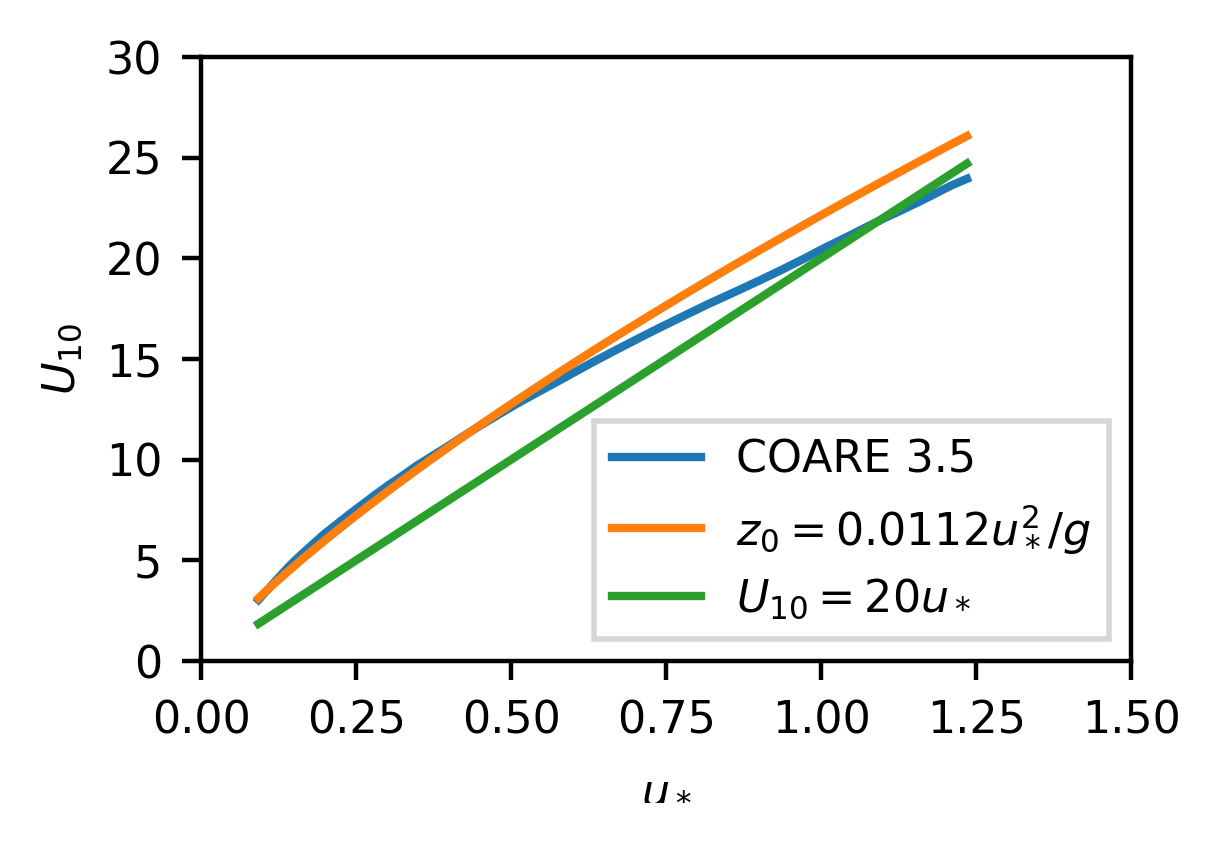

In [31]:
from scipy import interpolate
y = COARE.U10
x = (COARE.U10*(COARE.Cd*0.001)**0.5)
f = interpolate.interp1d(x,y)

plt.figure (figsize=[3,2])
plt.plot(x,y,label='COARE 3.5')
plt.plot(x,(x**2*np.log(10/(0.0112*x**2/9.8))**2/0.41**2)**0.5, label=r'$z_0 = 0.0112u_*^2/g$')
plt.plot(x,x*20, label=r'$U_{10}=20 u_*$')

plt.xlabel(r'$u_*$'); plt.ylabel(r'$U_{10}$'); plt.xlim([0,1.5]); plt.ylim([0,30])
plt.legend(fancybox=False)

In [ ]:
""" How was U10 computed? """

""" Write an interpolator """

figure = plt.figure(figsize=[3,2.5]); ax = plt.gca()


ensem_WCC = []
ensem_U10 = []

for config in (config1_1,config1_2,config2_1,config2_2,config2_3,config2_4,config2_5,config3_1,config3_2,config3_3):
    for case in config.cases:
        hist_aver = np.average(np.array(case.hist_ensem['hist_ensem']), axis=0)
        bins = case.hist_ensem['bins'] 
        bins = bins[1:] - (bins[2] - bins[1])/2
        case.second = 0
#         case.first = 0 
#         threshold = 1*(9.8*config.Hskp/config.kp)**0.5   
        for (bin_, hist_) in zip(bins, hist_aver):
            if bin_ > 2: # the 2m/s limit
#             if bin_ > threshold: # the 2m/s limit
                case.second += bin_**2*hist_/2**case.LEVEL/case.config.L0/(bins[2] - bins[1])
#                 case.first += bin_*hist_/2**case.LEVEL/case.config.L0/(bins[2] - bins[1])
        case.second = case.second*(bins[2] - bins[1])

        """ Compute U10: first from fetch-limited condition get u*, and then use Charnock relation """
        const = 1
        config.cp = (9.8/config.kp)**0.5
        ustar_P = (config.P*np.exp(-1.25)/0.016/(config.cp**0.53)*9.8**0.5)**(1/0.47)
        ustar = const*((config.Hskp/config.kp*9.8)/config.cp**1.5)**2
        print(ustar_P, ustar)
        U10 = (ustar**2*np.log(10/(0.0112*ustar**2/9.8))**2/0.41**2)**0.5
#         U10 = (ustar_P**2*np.log(10/(0.0112*ustar**2/9.8))**2/0.41**2)**0.5 # More noisy!
        ensem_U10.append(U10)
        gamma = 0.56
        plt.plot(U10, case.second*2*np.pi/9.8*gamma*100, c=case.config.cc, marker='^', markersize=4, markerfacecolor='None', markeredgewidth=1)
        ensem_WCC.append(case.second*2*np.pi/9.8*gamma*100)
        config.ustar = ustar
        print('L0 = %g, b = %g' %(case.config.L0, case.dEdt/(case.fifth+0.0001)*9.8))
        
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="plain", scilimits=(0,0))

# slope = (ensem_dEdt[-1] - ensem_dEdt[0])/(ensem_fifth[-1] - ensem_fifth[0])*9.8
# print(slope)
# intersect = - slope*ensem_fifth[0]/9.8 + ensem_dEdt[0]
# plt.plot(np.array(ensem_fifth)/9.8, slope*np.array(ensem_fifth)/9.8 + intersect, '--', color = 'gray', alpha=0.5)

ax.set_ylabel(r'$\frac{2\pi}{g}\gamma\int c^2\Lambda(c)dc (\%)$'); ax.set_xlabel(r'$U_{10} (m/s)$')

# ax.text(0.8,0.15,'$b=%.4f$' %slope, c='gray')
# ax.text(45,0.15,'$b=%.4f$' %slope, c='gray')
# ax.text(800, 800,'$b=%.4f$' %slope, c='gray')
# ax.text(32000, 800,'$b=%.4f$' %slope, c='gray')
# plt.xscale('log'); 
plt.yscale('log')
plt.ylim([0.001, 10])
plt.xlim([0, 30])